# Initialize notebook

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import math
import seaborn as sn
import statistics
from tqdm import tqdm
import time
from functools import partial
from operator import is_not
import pickle
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from math import sqrt

pd.set_option('display.max_columns', None)

In [2]:
# Constants
KITTI_DATASET = '/media/robesafe/SSD_SATA/KITTI_DATASET/'

# Load dataframe and pkl files

In [3]:
df = pd.read_csv (KITTI_DATASET+'kitti_gt.csv')
df_train = pd.read_csv (KITTI_DATASET+'kitti_train_gt.csv')
df_val = pd.read_csv (KITTI_DATASET+'kitti_val_gt.csv')

In [4]:
def objective_0(x):
    return 0

def objective_const(x, a):
        return a

def objective_log_f(x, a, b, c):
    return a * np.log(x)**b + c

def objective_f(x, a, b):
    return a * x + b

def objective_2f(x, a, b, c):
        return a * x**2 + b * x + c
    
def objective_3f(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

class Regression_model:
    def __init__(self, function, variables):
        self.function = function
        self.variables = variables
    def __str__(self):
        return "function = %s, variables = %s"%(self.function, self.variables)

class Regression_model_class:
    def __init__(self, model_car, model_pedestrian, model_cyclist):
        self.car = model_car
        self.pedestrian = model_pedestrian
        self.cyclist = model_cyclist
    def __str__(self):
        return "car: {%s},\npedestrian: {%s},\ncyclist: {%s}"%(self.car, self.pedestrian, self.cyclist)
        
class Regression_model_bb:
    def __init__(self, bb_complete, bb_incomplete):
        self.bb_complete = bb_complete
        self.bb_incomplete = bb_incomplete
    def __str__(self):
        return "bb_complete: {%s},\nbb_incomplete: {%s}"%(self.bb_complete, self.bb_incomplete)

In [5]:
height_model = None
pc_proj_refinement_model = None
with open('height_model.pkl', 'rb') as f:
    height_model = pickle.load(f)
with open('pc_proj_refinement_model.pkl', 'rb') as f:
    pc_proj_refinement_model = pickle.load(f)

In [6]:
print(height_model)

car: {bb_complete: {function = <function objective_log_f at 0x7ff799b1e048>, variables = [689.26985181  -2.0374056  -16.72954044]},
bb_incomplete: {function = <function objective_log_f at 0x7ff799b1e048>, variables = [651.02767472  -1.7506046  -29.32080446]}},
pedestrian: {function = <function objective_log_f at 0x7ff799b1e048>, variables = [1173.22871064   -2.52031575  -10.67344022]},
cyclist: {function = <function objective_log_f at 0x7ff799b1e048>, variables = [1050.87275107   -2.40355944  -12.05918045]}


In [7]:
print(pc_proj_refinement_model)

car: {function = <function objective_3f at 0x7ff799b1e2f0>, variables = [ 7.15935510e-05 -1.09793561e-02  4.48755047e-01 -1.06645317e+00]},
pedestrian: {function = <function objective_0 at 0x7ff7e81cb620>, variables = []},
cyclist: {function = <function objective_f at 0x7ff799b1e598>, variables = [-0.02618416 -0.30909785]}


# Execute both models

## Execute height model

In [8]:
def approximate_distance_height(type_name, top, bottom, bb_complete, model):
    height = bottom - top
    if type_name == 'Car':
        if bb_complete:
            f = model.car.bb_complete.function
            return f(height, *model.car.bb_complete.variables)
        else:
            f = model.car.bb_incomplete.function
            return f(height, *model.car.bb_incomplete.variables)
    elif type_name == 'Pedestrian':
        f = model.pedestrian.function
        return f(height, *model.pedestrian.variables)
    elif type_name == 'Cyclist':
        f = model.cyclist.function
        return f(height, *model.cyclist.variables)
    else:
        raise ValueError("Type must be Car, Pedestrian or Cyclist")

In [9]:
df_train['distance_height'] = df_train.apply(lambda row: approximate_distance_height(row['type'],
                                                                              row['top'],
                                                                              row['bottom'],
                                                                              not row['incomplete_2d_horizontal'],
                                                                              height_model), axis=1)
df_val['distance_height'] = df_val.apply(lambda row: approximate_distance_height(row['type'],
                                                                          row['top'],
                                                                          row['bottom'],
                                                                          not row['incomplete_2d_horizontal'],
                                                                          height_model), axis=1)

In [10]:
df_train

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,height,width,length,x,y,z,ry,distance,height_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom,distance_height
0,0,0,Pedestrian,0.00,0.0,-0.20,712.40,143.00,810.73,307.92,1.89,0.48,1.20,1.84,1.47,8.41,0.01,8.733533,164.92,98.33,0.21,False,False,8.597865
1,1,0,Car,0.00,0.0,1.85,387.63,181.54,423.81,203.12,1.67,1.87,3.69,-16.53,2.39,58.49,1.57,60.827897,21.58,36.18,-0.28,False,False,53.316196
2,1,1,Cyclist,0.00,3.0,-1.65,676.60,163.95,688.98,193.93,1.86,0.60,2.02,4.59,1.32,45.84,-1.55,46.088134,29.98,12.38,0.10,False,False,43.396508
3,2,0,Car,0.00,0.0,-1.67,657.39,190.13,700.07,223.39,1.41,1.58,4.36,3.18,2.27,34.38,-1.58,34.601296,33.26,42.68,0.09,False,False,36.825652
4,3,0,Car,0.00,0.0,1.55,614.24,181.78,727.31,284.77,1.57,1.73,4.15,1.00,1.75,13.22,1.62,13.372767,102.99,113.07,0.07,False,False,13.570701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27993,5983,8,Car,0.00,2.0,-1.72,668.22,167.79,726.04,215.88,1.56,1.48,3.36,2.95,1.42,25.30,-1.61,25.510956,48.09,57.82,0.11,False,False,26.950301
27994,5983,9,Car,0.00,1.0,-1.66,640.25,174.03,671.68,198.24,1.38,1.55,3.60,2.70,1.47,43.39,-1.60,43.498770,24.21,31.43,0.06,False,False,48.262606
27995,5983,10,Car,0.77,3.0,2.27,0.00,196.98,95.57,298.45,1.35,1.59,3.41,-9.21,1.73,10.06,1.55,13.748476,101.47,95.57,-0.72,True,False,15.359191
27996,5983,11,Car,0.00,2.0,-1.57,594.88,172.76,633.46,207.96,1.52,1.67,3.61,0.16,1.54,33.23,-1.56,33.266050,35.20,38.58,0.01,False,False,35.102942


## Execute pointcloud projection model

In [11]:
def get_point_cloud_projected(image_id):
    name = '%06d'%image_id # 6 digit zeropadding
    img = KITTI_DATASET+'images/'+name+'.png'
    binary = KITTI_DATASET+'velodyne/'+name+'.bin'
    with open(KITTI_DATASET+'calib/'+name+'.txt','r') as f:
        calib = f.readlines()

    # P2 (3 x 4) for left eye (intrinsic matrix in homogeneous coordinates)
    P2 = np.matrix([float(x) for x in calib[2].strip('\n').split(' ')[1:]]).reshape(3,4)
    R0_rect = np.matrix([float(x) for x in calib[4].strip('\n').split(' ')[1:]]).reshape(3,3)
    # Add a 1 in bottom-right, reshape to 4 x 4
    R0_rect = np.insert(R0_rect,3,values=[0,0,0],axis=0)
    R0_rect = np.insert(R0_rect,3,values=[0,0,0,1],axis=1)
    Tr_velo_to_cam = np.matrix([float(x) for x in calib[5].strip('\n').split(' ')[1:]]).reshape(3,4)
    Tr_velo_to_cam = np.insert(Tr_velo_to_cam,3,values=[0,0,0,1],axis=0)

    # read raw data from binary
    scan = np.fromfile(binary, dtype=np.float32).reshape((-1,4))
    points = scan[:, 0:3] # lidar xyz (front, left, up)
    # TODO: use fov filter? 
    velo = np.insert(points,3,1,axis=1).T
    velo = np.delete(velo,np.where(velo[0,:]<0),axis=1)
    
    cam = P2 * R0_rect * Tr_velo_to_cam * velo
    cam = np.delete(cam,np.where(cam[2,:]<0)[1],axis=1)
    # get u,v,z
    cam[:2] /= cam[2,:]
    png = mpimg.imread(img)
    IMG_H,IMG_W,_ = png.shape
    # filter point out of canvas
    u,v,z = cam
    u_out = np.logical_or(u<0, u>IMG_W)
    v_out = np.logical_or(v<0, v>IMG_H)
    outlier = np.logical_or(u_out, v_out)
    cam = np.delete(cam,np.where(outlier),axis=1)
    return cam

In [12]:
def get_bounding_boxes_2D(image_id):
    df_frame = df[df['frame'] == image_id]
    bbs = []
    for index, row in df_frame.iterrows():
        bb = (row['left'], row['top'], row['right'], row['bottom'])
        bbs.append(bb)
    return bbs

In [13]:
def approximate_distance_pc(image_id, model):
    bbs = get_bounding_boxes_2D(image_id)
    projected_pc = get_point_cloud_projected(image_id)
    types = df[df['frame'] == image_id]['type'].tolist()
    incomplete = df[df['frame'] == image_id]['incomplete_2d_horizontal'].tolist()
    
    
    # Sort bbs by height (change to sort by regression method using height)
    with open('height_model.pkl', 'rb') as f:
        height_model = pickle.load(f)
        id_bbs = sorted(list(range(len(bbs))),
                     key=lambda i: approximate_distance_height(types[i], bbs[i][1], bbs[i][3],
                                                        not incomplete[i], height_model))
        bbs = list(enumerate(bbs))
        types = list(enumerate(types))
        bbs.sort(key=lambda x: id_bbs.index(x[0]))
        types.sort(key=lambda x: id_bbs.index(x[0]))
        bbs = list(map(lambda x: x[1], bbs))
        types = list(map(lambda x: x[1], types))
        
    # Create output dict
    bbs_distance = {'frame':[image_id]*len(types),
                    'left':list(map(lambda x: x[0], bbs)),
                    'top':list(map(lambda x: x[1], bbs)),
                    'right':list(map(lambda x: x[2], bbs)),
                    'bottom':list(map(lambda x: x[3], bbs)),
                    'type':types,
                    'distance':[]}    
    
    # Iterate over bb
    for type_name, bb in zip(types, bbs):
        filter_bb = (bb[0] < projected_pc[0,:]) & (bb[1] < projected_pc[1,:]) &\
            (projected_pc[0,:] < bb[2]) & (projected_pc[1,:] < bb[3])
        pc_distance_bb = projected_pc[2,:][filter_bb]
        
        if pc_distance_bb.size != 0: # Checks if there's any point on the bb 2D
            # Approximate distance
            distance = np.median(np.squeeze(np.asarray(pc_distance_bb)))
            height = bb[3] - bb[1] # bottom - top
            if type_name == 'Car':
                f = model.car.function
                rectification = f(distance, *model.car.variables)
                distance += rectification
            elif type_name == 'Pedestrian':
                f = model.pedestrian.function
                rectification = f(distance, *model.pedestrian.variables)
                distance += rectification
            elif type_name == 'Cyclist':
                f = model.cyclist.function
                rectification = f(distance, *model.cyclist.variables)
                distance += rectification
            else:
                print("Type must be Car, Pedestrian or Cyclist")
            
            bbs_distance['distance'].append(distance)
        else:
            bbs_distance['distance'].append(None)
        
        # Removing points from the pointcloud in the bb
        filter_intersection = (bb[0] < projected_pc[0,:]) &\
                       (bb[1] < projected_pc[1,:]) &\
                       (projected_pc[0,:] < bb[2]) &\
                       (projected_pc[1,:] < bb[3])
        projected_pc = np.concatenate((projected_pc[0,:][~filter_intersection],\
                                       projected_pc[1,:][~filter_intersection],\
                                       projected_pc[2,:][~filter_intersection]), axis=0)
    
    return bbs_distance

In [14]:
loading_bar = tqdm(total=len(df['frame'].unique()), position=0, leave=True)
distance_approx = {'frame':[], 'left':[], 'top':[], 'right':[], 'bottom':[], 'type':[], 'distance':[]}
for frame in df['frame'].unique():
    frame_approx = approximate_distance_pc(frame, pc_proj_refinement_model)
    dict_items = ['frame','left','top','right','bottom','type','distance']
    for item in dict_items:
        distance_approx[item].extend(frame_approx[item])
    loading_bar.update(1)
df_approx = pd.DataFrame(columns = dict_items[:-1]+['distance_pointcloud'],
                         data = list(zip(distance_approx['frame'], distance_approx['left'],
                                         distance_approx['top'], distance_approx['right'],
                                         distance_approx['bottom'], distance_approx['type'],
                                         distance_approx['distance'])))

100%|█████████▉| 7479/7481 [02:28<00:00, 56.42it/s]

In [15]:
df_train = pd.merge(df_train, df_approx,  how='inner',
                  left_on=['frame','left','top','right','bottom','type'],
                  right_on=['frame','left','top','right','bottom','type'])
df_val = pd.merge(df_val, df_approx,  how='inner',
                  left_on=['frame','left','top','right','bottom','type'],
                  right_on=['frame','left','top','right','bottom','type'])

In [16]:
df_val

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,height,width,length,x,y,z,ry,distance,height_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom,distance_height,distance_pointcloud
0,5984,0,Car,0.0,1.0,3.10,431.50,171.26,514.83,204.10,1.49,1.46,3.84,-6.60,1.44,34.58,2.91,35.233649,32.84,83.33,-0.19,False,False,37.223531,38.266789
1,5984,1,Pedestrian,0.0,1.0,2.84,759.60,163.84,772.27,193.28,1.86,0.57,1.08,9.91,1.30,46.20,3.05,47.268786,29.44,12.67,0.21,False,False,43.724626,46.418030
2,5984,2,Car,0.0,0.0,1.22,699.42,157.64,744.58,190.94,2.21,1.76,4.11,7.73,1.22,50.24,1.37,50.845835,33.30,45.16,0.15,False,False,36.788248,51.989090
3,5984,3,Car,0.0,1.0,-2.01,729.47,164.21,774.61,189.74,1.75,1.57,4.07,10.11,1.18,51.72,-1.82,52.712075,25.53,45.14,0.19,False,False,46.111278,53.180900
4,5984,4,Car,0.0,0.0,-2.05,767.91,164.74,823.24,187.41,1.54,1.71,5.03,13.25,1.02,51.91,-1.80,53.584055,22.67,55.33,0.25,False,False,51.081492,54.453847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6853,7480,9,Car,0.0,2.0,-0.33,749.78,170.88,917.51,243.48,1.77,1.69,3.82,5.72,1.75,18.85,-0.04,19.776334,72.60,167.73,0.29,False,False,18.821832,23.025045
6854,7480,10,Car,0.0,1.0,-2.90,344.07,180.05,479.10,224.15,1.49,1.59,4.44,-7.12,1.78,26.03,3.12,27.044846,44.10,135.03,-0.26,False,False,29.010171,29.638311
6855,7480,11,Car,0.0,2.0,-2.91,382.70,179.71,495.48,219.10,1.48,1.63,4.10,-6.79,1.78,28.78,-3.14,29.623654,39.39,112.78,-0.23,False,False,31.921166,34.013135
6856,7480,12,Car,0.0,0.0,-1.69,631.71,179.85,678.40,214.37,1.41,1.56,4.08,1.90,1.74,31.98,-1.63,32.083610,34.52,46.69,0.06,False,False,35.686282,34.715410


# Analyze model error as dependent on attributes

In [17]:
df_train['error_distance_height'] = df_train['distance'] - df_train['distance_height']
df_val['error_distance_height'] = df_val['distance'] - df_val['distance_height']
df_train['error_distance_pointcloud'] = df_train['distance'] - df_train['distance_pointcloud']
df_val['error_distance_pointcloud'] = df_val['distance'] - df_val['distance_pointcloud']

In [18]:
df_train

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,height,width,length,x,y,z,ry,distance,height_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom,distance_height,distance_pointcloud,error_distance_height,error_distance_pointcloud
0,0,0,Pedestrian,0.00,0.0,-0.20,712.40,143.00,810.73,307.92,1.89,0.48,1.20,1.84,1.47,8.41,0.01,8.733533,164.92,98.33,0.21,False,False,8.597865,12.379818,0.135668,-3.646285
1,1,0,Car,0.00,0.0,1.85,387.63,181.54,423.81,203.12,1.67,1.87,3.69,-16.53,2.39,58.49,1.57,60.827897,21.58,36.18,-0.28,False,False,53.316196,58.928456,7.511702,1.899441
2,1,1,Cyclist,0.00,3.0,-1.65,676.60,163.95,688.98,193.93,1.86,0.60,2.02,4.59,1.32,45.84,-1.55,46.088134,29.98,12.38,0.10,False,False,43.396508,44.248675,2.691626,1.839459
3,2,0,Car,0.00,0.0,-1.67,657.39,190.13,700.07,223.39,1.41,1.58,4.36,3.18,2.27,34.38,-1.58,34.601296,33.26,42.68,0.09,False,False,36.825652,38.057486,-2.224356,-3.456190
4,3,0,Car,0.00,0.0,1.55,614.24,181.78,727.31,284.77,1.57,1.73,4.15,1.00,1.75,13.22,1.62,13.372767,102.99,113.07,0.07,False,False,13.570701,15.194321,-0.197934,-1.821554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27993,5983,8,Car,0.00,2.0,-1.72,668.22,167.79,726.04,215.88,1.56,1.48,3.36,2.95,1.42,25.30,-1.61,25.510956,48.09,57.82,0.11,False,False,26.950301,43.970196,-1.439345,-18.459240
27994,5983,9,Car,0.00,1.0,-1.66,640.25,174.03,671.68,198.24,1.38,1.55,3.60,2.70,1.47,43.39,-1.60,43.498770,24.21,31.43,0.06,False,False,48.262606,45.390958,-4.763836,-1.892188
27995,5983,10,Car,0.77,3.0,2.27,0.00,196.98,95.57,298.45,1.35,1.59,3.41,-9.21,1.73,10.06,1.55,13.748476,101.47,95.57,-0.72,True,False,15.359191,9.317900,-1.610715,4.430576
27996,5983,11,Car,0.00,2.0,-1.57,594.88,172.76,633.46,207.96,1.52,1.67,3.61,0.16,1.54,33.23,-1.56,33.266050,35.20,38.58,0.01,False,False,35.102942,NaN,-1.836891,NaN


## Analyze height model error

### Error base on approximate distance

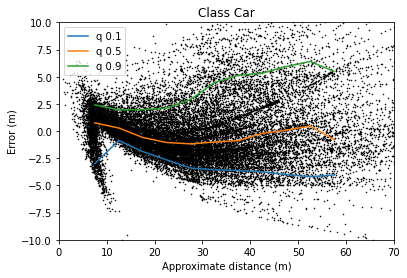

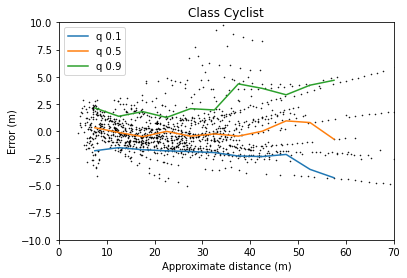

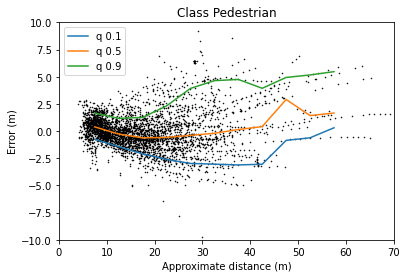

In [19]:
jump = 5
start = 5
end = 60

# Loop over classes
for class_name in ["Car","Cyclist","Pedestrian"]:
    df_train_class = df_train[df_train['type'] == class_name]
    
    # Calculate quartiles
    MDistanceE_distances = []
    for distance in range(start, end, jump):
        MDistanceE_distance = df_train_class[(distance < df_train_class['distance_height']) & \
                                           (df_train_class['distance_height'] < distance+jump)].apply(lambda row: row['distance']-row['distance_height'],
                                                                                                    axis=1).quantile(q=[0.1,0.5,0.9])
        MDistanceE_distances.append(MDistanceE_distance)
    q_0_1 = list(map(lambda x: x.get(0.1), MDistanceE_distances))
    q_0_5 = list(map(lambda x: x.get(0.5), MDistanceE_distances))
    q_0_9 = list(map(lambda x: x.get(0.9), MDistanceE_distances))

    Y = df_train_class['error_distance_height'].values
    X = df_train_class['distance_height'].values

    plt.title("Class %s" % class_name)
    plt.xlabel('Approximate distance (m)')
    plt.ylabel('Error (m)')

    plt.scatter(X, Y, s=0.3, c='black')
    
    x = np.array(list(range(start,end,jump)))+jump/2
    plt.plot(x, q_0_1)
    plt.plot(x, q_0_5)
    plt.plot(x, q_0_9)
    plt.legend(['q 0.1', 'q 0.5', 'q 0.9'])
    
    plt.xlim((0,70))
    plt.ylim((-10,10))
    
    #plt.grid(alpha=0.5)
    
    plt.show()

### Error base on height

In [20]:
print(min(df['height_image']))
print(max(df['height_image']))

12.670000000000016
334.53


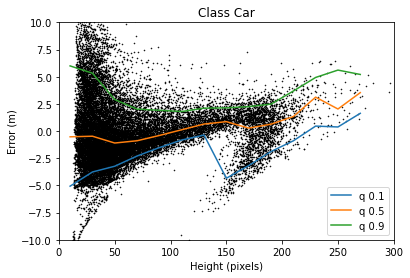

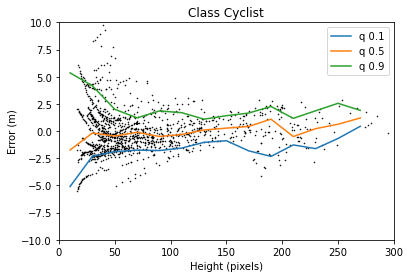

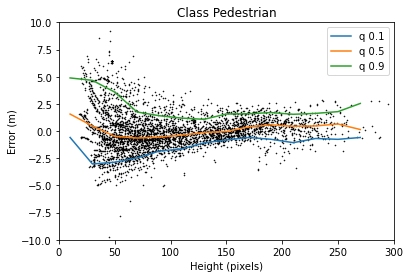

In [21]:
jump = 20
start = 0
end = 280

# Loop over classes
for class_name in ["Car","Cyclist","Pedestrian"]:
    df_train_class = df_train[df_train['type'] == class_name]
    
    # Calculate quartiles
    MHeightE_heigths = []
    for height in range(start, end, jump):
        MHeightE_heigth = df_train_class[(height < df_train_class['height_image']) & \
                                           (df_train_class['height_image'] < height+jump)].apply(lambda row: row['distance']-row['distance_height'],
                                                                                                    axis=1).quantile(q=[0.1,0.5,0.9])
        MHeightE_heigths.append(MHeightE_heigth)
    q_0_1 = list(map(lambda x: x.get(0.1), MHeightE_heigths))
    q_0_5 = list(map(lambda x: x.get(0.5), MHeightE_heigths))
    q_0_9 = list(map(lambda x: x.get(0.9), MHeightE_heigths))

    Y = df_train_class['error_distance_height'].values
    X = df_train_class['height_image'].values

    plt.title("Class %s" % class_name)
    plt.xlabel('Height (pixels)')
    plt.ylabel('Error (m)')

    plt.scatter(X, Y, s=0.3, c='black')
    
    x = np.array(list(range(start,end,jump)))+jump/2
    plt.plot(x, q_0_1)
    plt.plot(x, q_0_5)
    plt.plot(x, q_0_9)
    plt.legend(['q 0.1', 'q 0.5', 'q 0.9'])
    
    plt.xlim((0,300))
    plt.ylim((-10,10))
    
    #plt.grid(alpha=0.5)
    
    plt.show()

## Analyze pointcloud model error

In [22]:
def get_n_points_pc_projection_without_intersections(image_id):
    bbs = get_bounding_boxes_2D(image_id)
    projected_pc = get_point_cloud_projected(image_id)
    
    bbs_n_points = [[],[]]
    # Sort bbs by height
    bbs = sorted(bbs, key=lambda bb: bb[3]-bb[1], reverse=True)
    # Iterate over bb
    for bb in bbs:
        filter_bb = (bb[0] < projected_pc[0,:]) & (bb[1] < projected_pc[1,:]) &\
            (projected_pc[0,:] < bb[2]) & (projected_pc[1,:] < bb[3])
        pc_distance_bb = projected_pc[2,:][filter_bb]
        
        if pc_distance_bb.size != 0: # Checks if there's any point on the bb 2D
            bbs_n_points[0].append(bb)
            bbs_n_points[1].append(pc_distance_bb.size)
        
        # Removing points from the pointcloud in the bb
        filter_intersection = (bb[0] < projected_pc[0,:]) &\
                       (bb[1] < projected_pc[1,:]) &\
                       (projected_pc[0,:] < bb[2]) &\
                       (projected_pc[1,:] < bb[3])
        projected_pc = np.concatenate((projected_pc[0,:][~filter_intersection],\
                                       projected_pc[1,:][~filter_intersection],\
                                       projected_pc[2,:][~filter_intersection]), axis=0)
    
    return bbs_n_points

In [23]:
frame_list, left_list, top_list, right_list, bottom_list, n_points_list = [], [], [], [], [], []
loading_bar = tqdm(total=len(df['frame'].unique()), position=0, leave=True)
# Iterate over frames
for frame in df['frame'].unique():
    # Get distance approimation using 2nd method
    bbs2D, n_points = get_n_points_pc_projection_without_intersections(frame)
    # Fill columns data in lists
    frame_list.extend(len(n_points)*[frame])
    ## Iterate over bbs2D
    for bb2D in bbs2D:
        left_list.append(bb2D[0])
        top_list.append(bb2D[1])
        right_list.append(bb2D[2])
        bottom_list.append(bb2D[3])
    n_points_list.extend(n_points)
    
    loading_bar.update(1)
df_approx = pd.DataFrame(columns = ['frame','left','top','right','bottom','n_points'],
                         data = list(zip(frame_list, left_list, top_list, right_list, bottom_list, n_points_list)))

100%|█████████▉| 7478/7481 [01:59<00:00, 62.21it/s]

In [24]:
df_approx

,frame,left,top,right,bottom,n_points
0,0,712.40,143.00,810.73,307.92,1463
1,1,676.60,163.95,688.98,193.93,27
2,1,387.63,181.54,423.81,203.12,12
3,2,657.39,190.13,700.07,223.39,111
4,3,614.24,181.78,727.31,284.77,1016
...,...,...,...,...,...,...
34010,7480,501.01,178.40,523.53,228.03,112
34011,7480,344.07,180.05,479.10,224.15,380
34012,7480,382.70,179.71,495.48,219.10,56
34013,7480,631.71,179.85,678.40,214.37,121


In [25]:
df_train = pd.merge(df_train, df_approx,  how='inner',
                  left_on=['frame','left','top','right','bottom'],
                  right_on=['frame','left','top','right','bottom'])
df_val = pd.merge(df_val, df_approx,  how='inner',
                  left_on=['frame','left','top','right','bottom'],
                  right_on=['frame','left','top','right','bottom'])

In [26]:
df_val

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,height,width,length,x,y,z,ry,distance,height_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom,distance_height,distance_pointcloud,error_distance_height,error_distance_pointcloud,n_points
0,5984,0,Car,0.0,1.0,3.10,431.50,171.26,514.83,204.10,1.49,1.46,3.84,-6.60,1.44,34.58,2.91,35.233649,32.84,83.33,-0.19,False,False,37.223531,38.266789,-1.989883,-3.033141,228
1,5984,1,Pedestrian,0.0,1.0,2.84,759.60,163.84,772.27,193.28,1.86,0.57,1.08,9.91,1.30,46.20,3.05,47.268786,29.44,12.67,0.21,False,False,43.724626,46.418030,3.544160,0.850756,27
2,5984,2,Car,0.0,0.0,1.22,699.42,157.64,744.58,190.94,2.21,1.76,4.11,7.73,1.22,50.24,1.37,50.845835,33.30,45.16,0.15,False,False,36.788248,51.989090,14.057587,-1.143255,50
3,5984,3,Car,0.0,1.0,-2.01,729.47,164.21,774.61,189.74,1.75,1.57,4.07,10.11,1.18,51.72,-1.82,52.712075,25.53,45.14,0.19,False,False,46.111278,53.180900,6.600798,-0.468825,18
4,5984,4,Car,0.0,0.0,-2.05,767.91,164.74,823.24,187.41,1.54,1.71,5.03,13.25,1.02,51.91,-1.80,53.584055,22.67,55.33,0.25,False,False,51.081492,54.453847,2.502564,-0.869791,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6696,7480,9,Car,0.0,2.0,-0.33,749.78,170.88,917.51,243.48,1.77,1.69,3.82,5.72,1.75,18.85,-0.04,19.776334,72.60,167.73,0.29,False,False,18.821832,23.025045,0.954502,-3.248711,449
6697,7480,10,Car,0.0,1.0,-2.90,344.07,180.05,479.10,224.15,1.49,1.59,4.44,-7.12,1.78,26.03,3.12,27.044846,44.10,135.03,-0.26,False,False,29.010171,29.638311,-1.965325,-2.593465,380
6698,7480,11,Car,0.0,2.0,-2.91,382.70,179.71,495.48,219.10,1.48,1.63,4.10,-6.79,1.78,28.78,-3.14,29.623654,39.39,112.78,-0.23,False,False,31.921166,34.013135,-2.297512,-4.389481,56
6699,7480,12,Car,0.0,0.0,-1.69,631.71,179.85,678.40,214.37,1.41,1.56,4.08,1.90,1.74,31.98,-1.63,32.083610,34.52,46.69,0.06,False,False,35.686282,34.715410,-3.602672,-2.631800,121


### Error base on approximate distance

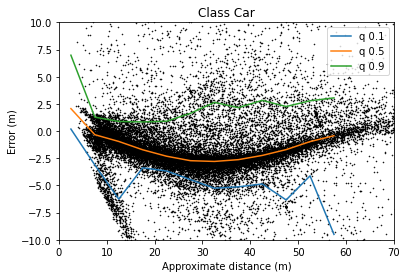

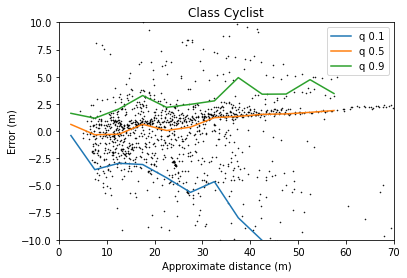

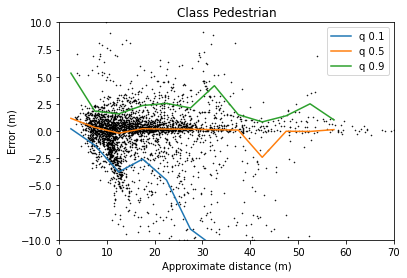

In [27]:
jump = 5
start = 0
end = 60

# Loop over classes
for class_name in ["Car","Cyclist","Pedestrian"]:
    df_train_class = df_train[df_train['type'] == class_name]
    
    # Calculate quartiles
    MDistanceE_distances = []
    for distance in range(start, end, jump):
        MDistanceE_distance = df_train_class[(distance < df_train_class['distance_pointcloud']) & \
                                           (df_train_class['distance_pointcloud'] < distance+jump)].apply(lambda row: row['distance']-row['distance_pointcloud'],
                                                                                                    axis=1).quantile(q=[0.1,0.5,0.9])
        MDistanceE_distances.append(MDistanceE_distance)
    q_0_1 = list(map(lambda x: x.get(0.1), MDistanceE_distances))
    q_0_5 = list(map(lambda x: x.get(0.5), MDistanceE_distances))
    q_0_9 = list(map(lambda x: x.get(0.9), MDistanceE_distances))

    Y = df_train_class['error_distance_pointcloud'].values
    X = df_train_class['distance_pointcloud'].values

    plt.title("Class %s" % class_name)
    plt.xlabel('Approximate distance (m)')
    plt.ylabel('Error (m)')

    plt.scatter(X, Y, s=0.3, c='black')
    
    x = np.array(list(range(start,end,jump)))+jump/2
    plt.plot(x, q_0_1)
    plt.plot(x, q_0_5)
    plt.plot(x, q_0_9)
    plt.legend(['q 0.1', 'q 0.5', 'q 0.9'])
    
    plt.xlim((0,70))
    plt.ylim((-10,10))
    
    #plt.grid(alpha=0.5)
    
    plt.show()

### Error base on pointcloud density

In [28]:
print(min(df_train['n_points']))
print(max(df_train['n_points']))

1
5761


array([[<AxesSubplot:title={'center':'n_points'}>]], dtype=object)

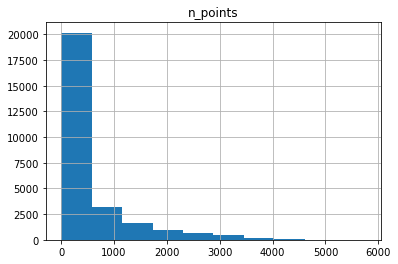

In [29]:
df_train.hist(column='n_points')

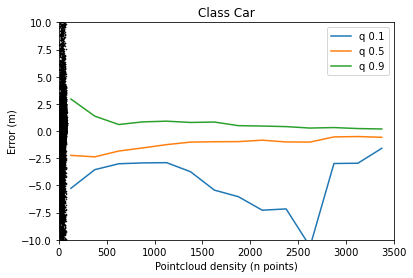

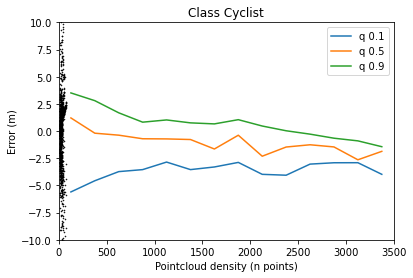

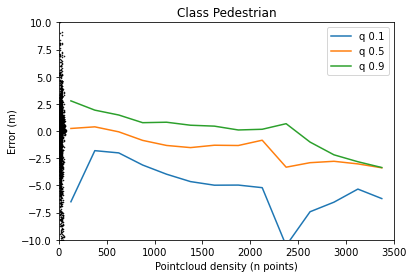

In [30]:
jump = 250
start = 0
end = 3500

# Loop over classes
for class_name in ["Car","Cyclist","Pedestrian"]:
    df_train_class = df_train[df_train['type'] == class_name]
    
    # Calculate quartiles
    MPointE_points = []
    for point in range(start, end, jump):
        MPointE_point = df_train_class[(point < df_train_class['n_points']) & \
                                           (df_train_class['n_points'] < point+jump)].apply(lambda row: row['distance']-row['distance_pointcloud'],
                                                                                                    axis=1).quantile(q=[0.1,0.5,0.9])
        MPointE_points.append(MPointE_point)
    q_0_1 = list(map(lambda x: x.get(0.1), MPointE_points))
    q_0_5 = list(map(lambda x: x.get(0.5), MPointE_points))
    q_0_9 = list(map(lambda x: x.get(0.9), MPointE_points))

    Y = df_train_class['error_distance_pointcloud'].values
    X = df_train_class['distance_pointcloud'].values

    plt.title("Class %s" % class_name)
    plt.xlabel('Pointcloud density (n points)')
    plt.ylabel('Error (m)')

    plt.scatter(X, Y, s=0.3, c='black')
    
    x = np.array(list(range(start,end,jump)))+jump/2
    plt.plot(x, q_0_1)
    plt.plot(x, q_0_5)
    plt.plot(x, q_0_9)
    plt.legend(['q 0.1', 'q 0.5', 'q 0.9'])
    
    plt.xlim((0,3500))
    plt.ylim((-10,10))
    
    #plt.grid(alpha=0.5)
    
    plt.show()

# Create ensemble method

## Create error functions

Due to the possible appearance of a value not found in the training dataset, a function is created to infer the error range for any value.

In [31]:
class Regression_model_error:
    def __init__(self, height_distance, height_2d, pointcloud_distance, pointcloud_n_points):
        self.height_distance = height_distance
        self.height_2d = height_2d
        self.pointcloud_distance = pointcloud_distance
        self.pointcloud_n_points = pointcloud_n_points
    def __str__(self):
        return "height_distance: {%s},\nheight_2d: {%s},\npointcloud_distance: {%s},\npointcloud_n_points: {%s}"%\
                                (self.height_distance, self.height_2d, self.pointcloud_distance, self.pointcloud_n_points)

height_distance
Car
<function objective_8f at 0x7ff77600e378>
[ 6.62828093e-12 -1.04481465e-12 -2.23333757e-07  2.83676029e-05
 -1.55720497e-03  4.34684802e-02 -5.98359703e-01  3.46064730e+00
 -1.14886780e+00]
[1.0803813349452986, 0.4220332782240509, 0.3769344970383811, 0.30724680511227076, 0.234580143826022, 0.074885845162016, 0.07449490373921867]


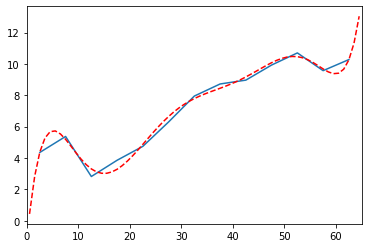

height_distance
Cyclist
<function objective_8f at 0x7ff77600e378>
[-4.21074119e-11  1.01987471e-08 -1.02123796e-06  5.52621058e-05
 -1.77995910e-03  3.53311218e-02 -4.19169480e-01  2.60283384e+00
 -2.70691731e+00]
[0.5596652496159467, 0.5592895005497154, 0.5141453373448271, 0.4446470481159797, 0.3298675945884391, 0.29962974518168306, 0.28389546884619665]


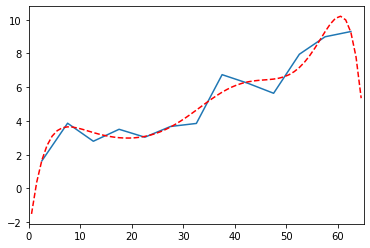

height_distance
Pedestrian
<function objective_8f at 0x7ff77600e378>
[ 3.79892872e-11 -9.11600898e-09  8.72304768e-07 -4.22048310e-05
  1.08486301e-03 -1.47179639e-02  1.15076833e-01 -5.86151601e-01
  4.03037710e+00]
[0.7903405882812683, 0.770949065881076, 0.149566005510459, 0.13811202519218221, 0.09982459843064567, 0.06860581105222786, 0.05579919391544974]


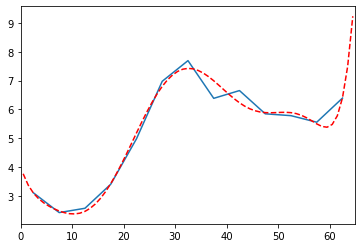

height_2d
Car
<function objective_8f at 0x7ff77600e378>
[-1.29801518e-16  8.96294667e-14 -1.59841684e-11 -1.68068020e-09
  8.11951991e-07 -8.28084225e-05  3.37475753e-03 -1.68362255e-01
  1.24641869e+01]
[2.165804457673078, 0.7886308630547233, 0.7771486066731335, 0.6478778124761131, 0.4764017254404829, 0.3303190121800323, 0.3276969715458913]


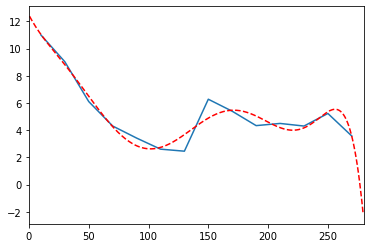

height_2d
Cyclist
<function objective_8f at 0x7ff77600e378>
[-1.02706703e-15  1.14727535e-12 -5.25947324e-10  1.27325727e-07
 -1.74198921e-05  1.33063374e-03 -5.13580656e-02  6.89030442e-01
  7.60834566e+00]
[1.8186069384756867, 0.4769338070859848, 0.4367397094790178, 0.35185176943229174, 0.3438335703667713, 0.3433995731430442, 0.17911943289126922]


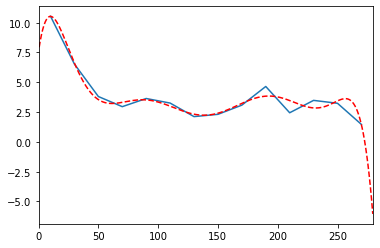

height_2d
Pedestrian
<function objective_8f at 0x7ff77600e378>
[ 2.78848227e-17 -2.51153314e-14  6.73197514e-12  4.74925562e-10
 -6.13911647e-07  1.31274234e-04 -1.21394501e-02  4.22113337e-01
  2.88038468e+00]
[0.4666029364748045, 0.4576740153396894, 0.27686010060829913, 0.06873075155359527, 0.03381321038935364, 0.03205535907000255, 0.03193445848684812]


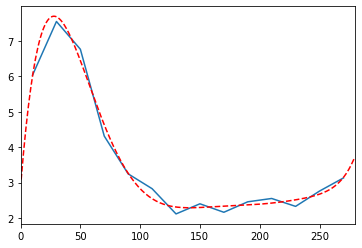

pointcloud_distance
Car
<function objective_8f at 0x7ff77600e378>
[ 6.05169827e-10 -1.46809553e-07  1.47410801e-05 -7.90834073e-04
  2.43938740e-02 -4.32931931e-01  4.17742154e+00 -1.90578121e+01
  3.42068451e+01]
[1.7138917858366274, 1.7138592989348884, 1.3243927711061976, 0.9347510817737797, 0.746333627946849, 0.7104223164980891, 0.03982102116847155]


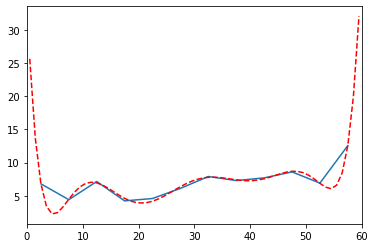

pointcloud_distance
Cyclist
<function objective_8f at 0x7ff77600e378>
[-4.54361398e-11  1.46267010e-08 -1.78732370e-06  1.10592253e-04
 -3.80130878e-03  7.40732488e-02 -7.92290963e-01  4.34567127e+00
 -4.88269753e+00]
[8.521348655102026, 3.4239999464834443, 2.522184434746387, 1.241335710389471, 0.7197079987570341, 0.5175725431128277, 0.5137921595838814]


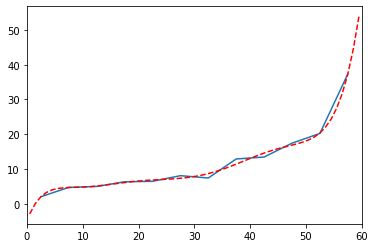

pointcloud_distance
Pedestrian
<function objective_8f at 0x7ff77600e378>
[ 2.02704878e-10 -5.72068722e-08  6.49493742e-06 -3.83435371e-04
  1.26900982e-02 -2.36682864e-01  2.38045370e+00 -1.12918180e+01
  2.17018487e+01]
[6.577726606416249, 5.138722367809951, 2.749018488913897, 2.7070850499583443, 1.4197427936742988, 0.3511442803209794, 0.2759303833688917]


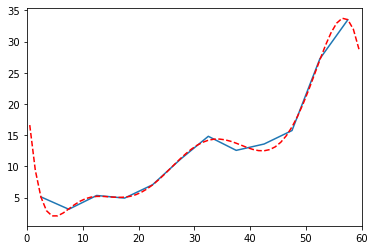

pointcloud_n_points
Car
<function objective_8f at 0x7ff77600e378>
[-6.51694893e-25  9.63143823e-21 -5.75628927e-17  1.78907940e-13
 -3.09295320e-10  2.91804508e-07 -1.29754666e-04  1.27398335e-02
  8.10821891e+00]
[5.261540282403226, 1.723203348902367, 1.565551978232891, 1.4383931995066763, 1.1826687367077688, 1.1551432409379747, 1.131600444997316]


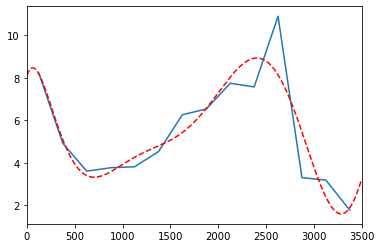

pointcloud_n_points
Cyclist
<function objective_8f at 0x7ff77600e378>
[-5.35502100e-25  7.51356719e-21 -4.34601905e-17  1.34247428e-13
 -2.39343770e-10  2.46012671e-07 -1.32654432e-04  2.47555914e-02
  7.65257099e+00]
[0.6109758575787712, 0.289583062865534, 0.11527744912640843, 0.044643752183174366, 0.042685896477941423, 0.04265666521626076, 0.026794895357471878]


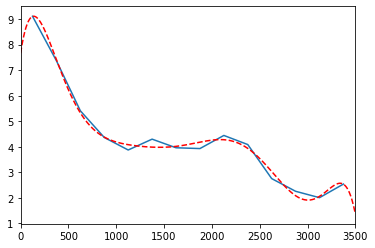

pointcloud_n_points
Pedestrian
<function objective_8f at 0x7ff77600e378>
[-1.81667732e-24  2.55710069e-20 -1.45803981e-16  4.31170831e-13
 -7.01615011e-10  6.09082964e-07 -2.40941276e-04  1.98629553e-02
  9.46619868e+00]
[5.047796991097158, 2.533049248354885, 2.1426709443053893, 2.134689859881314, 1.170262179341428, 1.1682411107390285, 0.9856069819190726]


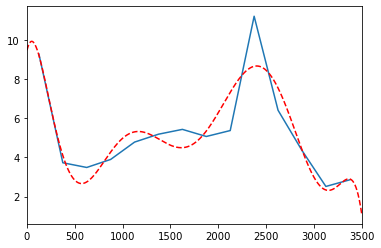

In [32]:
# Fuctions to fit
def objective_2f(x, a, b, c):
    return a * x**2 + b * x + c

def objective_3f(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def objective_4f(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e

def objective_5f(x, a, b, c, d, e, f):
    return a * x**5 + b * x**4 + c * x**3 + d * x**2 + e * x + f

def objective_6f(x, a, b, c, d, e, f, g):
    return a * x**6 + b * x**5 + c * x**4 + d * x**3 + e * x**2 + f * x + g

def objective_7f(x, a, b, c, d, e, f, g, h):
    return a * x**7 + b * x**6 + c * x**5 + d * x**4 + e * x**3 + f * x**2 + g * x + h

def objective_8f(x, a, b, c, d, e, f, g, h, i):
    return a * x**8 + b * x**7 + c * x**6 + d * x**5 + e * x**4 + f * x**3 + g * x**2 + h * x + i

def objective_9f(x, a, b, c, d, e, f, g, h, i, j):
    return a * x**9 + b * x**8 + c * x**7 + d * x**6 + e * x**5 + f * x**4 + g * x**3 + h * x**2 + i * x + j

def objective_10f(x, a, b, c, d, e, f, g, h, i, j, k):
    return a * x**10 + b * x**9 + c * x**8 + d * x**7 + e * x**6 + f * x**5 + g * x**4 + h * x**3 + i * x**2 + j * x + k
 
# Variables for the different error models
jumps = [5, 20, 5, 250]
starts = [0, 0, 0, 0]
ends = [65, 280, 60, 3500]

functions = [objective_2f, objective_3f, objective_4f, objective_5f, objective_6f, objective_7f, objective_8f]
error_model_names = ['height_distance', 'height_2d', 'pointcloud_distance', 'pointcloud_n_points']
model_columns = ['distance_height', 'height_image', 'distance_pointcloud', 'n_points']
class_names = ['Car', 'Cyclist', 'Pedestrian']

# Loop over error models
for error_model_name, model_column, jump, start, end in zip(error_model_names, model_columns,jumps, starts, ends):
    # Loop over class names
    for class_name in class_names:
        
        approximate_distance_column = 'distance_' + error_model_name.split("_")[0]
        
        df_train_class = df_train[df_train['type'] == class_name]
    
        # Calculate deciles
        MPointE_points = []
        for point in range(start, end, jump):
            MPointE_point = df_train_class[(point < df_train_class[model_column]) & \
                                               (df_train_class[model_column] < point+jump)].apply(lambda row: row['distance']-row[approximate_distance_column],
                                                                                                        axis=1).quantile(q=[0.1,0.9])
            MPointE_points.append(MPointE_point)
        q_0_1 = list(map(lambda x: x.get(0.1), MPointE_points))
        q_0_9 = list(map(lambda x: x.get(0.9), MPointE_points))

        # Create axis
        Y = [x1 - x2 for (x1, x2) in zip(q_0_9, q_0_1)]
        X = (np.array(list(range(start,end,jump)))+jump/2).tolist()
        
        popt_functions = list(map(lambda function: curve_fit(function, X, Y,maxfev = 1000000)[0], functions))
        mses_class_model_error = list(map(lambda function, popt: mean_squared_error(Y, list(map(lambda x: function(x, *popt), X))), functions, popt_functions))
        
        min_mse = min(mses_class_model_error)
        id_function = mses_class_model_error.index(min_mse)
        function = functions[id_function]
        popt = popt_functions[id_function]
        
        X_line = (np.array(list(range(start,end,1)))+1/2).tolist()
        
        print(error_model_name)
        print(class_name)
        print(function)
        print(popt)
        print(mses_class_model_error)
        plt.plot(X, Y)
        plt.plot(X_line, list(map(lambda x: function(x, *popt), X_line)), '--', color='red')
        plt.xlim((start,end))
        plt.show()

Reduce the overfitting

height_distance
Car
<function objective_6f at 0x7ff77600e268>
[-1.59431958e-08  3.33478419e-06 -2.65003701e-04  9.75563508e-03
 -1.59126521e-01  9.69609309e-01  2.96461651e+00]
[1.0107831768920004, 0.4060665575996938, 0.3650255055820828, 0.25836710480503633, 0.18483330110818477, 0.21677453713218675, 0.21579102872076059, 0.8244558198080805, 1.234267898970692]


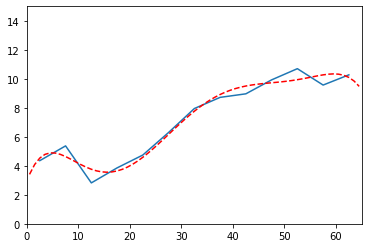

height_distance
Cyclist
<function objective_6f at 0x7ff77600e268>
[-2.00376464e-08  4.13289471e-06 -3.29768115e-04  1.27233997e-02
 -2.38976949e-01  1.97305661e+00 -1.99989155e+00]
[0.28783484678521537, 0.29016800916967983, 0.3455296490991841, 0.23389252192283425, 0.2083746703520762, 0.2578042691188576, 0.22912965231793278, 0.7047755271271351, 0.9418207543820589]


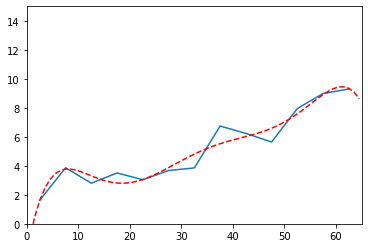

height_distance
Pedestrian
<function objective_10f at 0x7ff77600e488>
[-4.07009946e-14  9.70725797e-12 -7.83267633e-10  9.69580541e-09
  2.36736650e-06 -1.69124375e-04  5.29634098e-03 -8.79782312e-02
  7.85267179e-01 -3.44059477e+00  7.98077404e+00]
[0.6954121864074598, 0.6862475622529739, 0.3230776599197253, 0.3080025877895187, 0.2792658302358876, 0.3008340986263403, 0.31145860809203385, 0.20785761995924723, 0.18375997015510534]


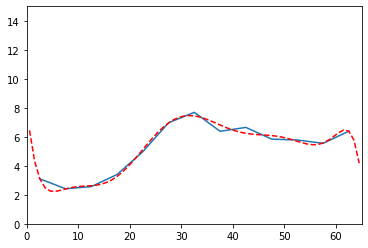

height_2d
Car
<function objective_9f at 0x7ff77600e400>
[ 1.46377930e-17 -1.85732232e-14  9.88570248e-12 -2.86834498e-09
  4.94102528e-07 -5.16854744e-05  3.22877669e-03 -1.12739942e-01
  1.77870292e+00  1.73168510e+00]
[1.8125008867083683, 0.7059342981362403, 0.7245716425743374, 0.6417682602960433, 0.6079297198091592, 0.5747576942771075, 0.5892666736654613, 0.4360747577954507, 0.7355720479586177]


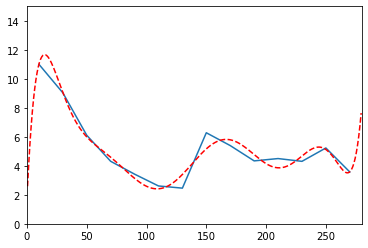

height_2d
Cyclist
<function objective_10f at 0x7ff77600e488>
[ 3.04072538e-19 -4.24172694e-16  2.53307948e-13 -8.45922804e-11
  1.73191580e-08 -2.24306096e-06  1.83231116e-04 -9.15327339e-03
  2.63329352e-01 -3.99701695e+00  3.17109453e+01]
[1.8619465771755386, 0.6667143067117217, 0.6634155518407883, 0.7931580334422574, 0.7370030092340177, 0.7495409307671997, 0.9004480978375506, 0.8826593047869437, 0.39161822713532957]


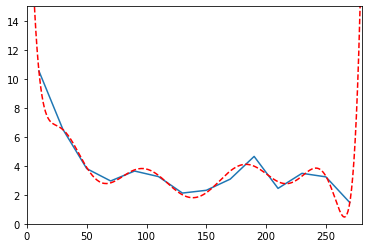

height_2d
Pedestrian
<function objective_10f at 0x7ff77600e488>
[ 5.18231556e-20 -7.84958798e-17  5.11912450e-14 -1.87896519e-11
  4.25700851e-09 -6.13640913e-07  5.58333264e-05 -3.05906575e-03
  9.07062833e-02 -1.20176648e+00  1.15370303e+01]
[0.5117937253562318, 0.537599535273803, 0.39689936867219733, 0.2901511649896187, 0.29799885513536795, 0.2991745495483577, 0.2901759455964077, 0.23517687810181115, 0.1159883331640712]


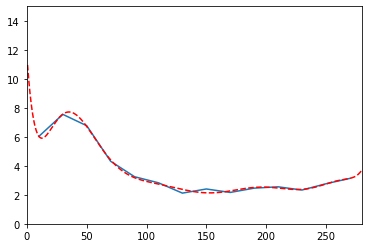

pointcloud_distance
Car
<function objective_8f at 0x7ff77600e378>
[ 6.05169827e-10 -1.46809553e-07  1.47410801e-05 -7.90834073e-04
  2.43938740e-02 -4.32931931e-01  4.17742154e+00 -1.90578121e+01
  3.42068451e+01]
[1.761067509783819, 1.7607244226334637, 1.8585461398758476, 1.6471983216252217, 1.2744255784087632, 1.157860686563803, 0.843783382176214, 1.076107105551585, 2.2860369112660552]


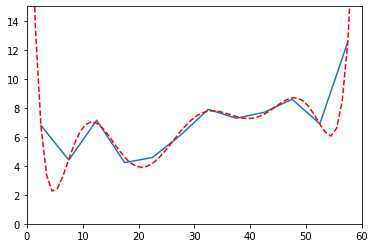

pointcloud_distance
Cyclist
<function objective_6f at 0x7ff77600e268>
[ 7.30318177e-08 -1.16539000e-05  6.96112421e-04 -1.89235238e-02
  2.27042479e-01 -7.42569003e-01  2.90605091e+00]
[3.4725727893521094, 1.782070184412416, 1.4226282269064778, 1.1542954945997879, 1.1038389509138127, 1.5037699959535864, 1.4965092318790645, 2.141283090307119, 5.303518264870293]


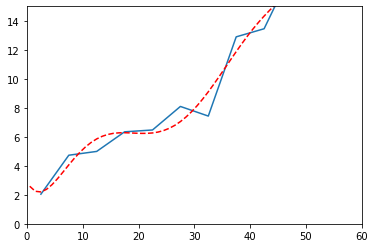

pointcloud_distance
Pedestrian
<function objective_4f at 0x7ff7764678c8>
[ 2.79259118e-05 -3.04222136e-03  1.13207578e-01 -1.29324607e+00
  7.77865388e+00]
[6.354288667161532, 4.836538349332201, 2.0727667067985425, 2.285187987605771, 4.01527838020781, 5.264576176693002, 4.325809562466117, 5.6916887704679935, 11.415220978767751]


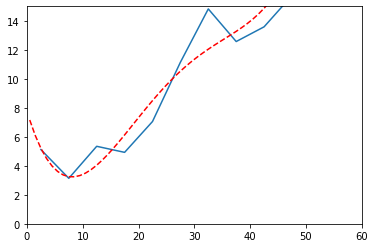

pointcloud_n_points
Car
<function objective_7f at 0x7ff77600e1e0>
[ 5.07329057e-22 -5.03957821e-18  1.86191224e-14 -3.06233035e-11
  1.62023355e-08  1.59931686e-05 -2.26262976e-02  1.07671114e+01]
[5.9008472565678955, 1.9528261339490802, 2.2129219985243873, 2.250104093753766, 1.7063201339532978, 1.4964385288081723, 1.5787026563887887, 1.7703571972830963, 5.565265826906378]


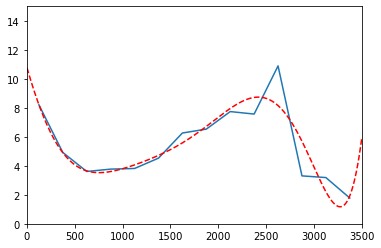

pointcloud_n_points
Cyclist
<function objective_10f at 0x7ff77600e488>
[ 1.22253706e-30 -2.14875683e-26  1.61917789e-22 -6.83543042e-19
  1.77287274e-15 -2.91471055e-12  3.02410389e-09 -1.91058062e-06
  6.85752793e-04 -1.29088782e-01  1.76057491e+01]
[0.8989407468120286, 0.5166001703754733, 0.4115329873793556, 0.39414983912171075, 0.3985864587124383, 0.39797352097722316, 0.44820032256254316, 0.4706191379562886, 0.32506257358630103]


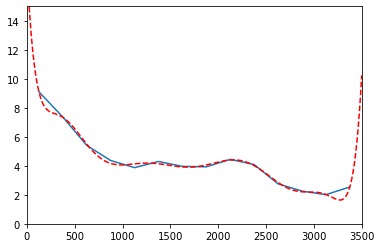

pointcloud_n_points
Pedestrian
<function objective_9f at 0x7ff77600e400>
[-3.15040109e-27  4.78014306e-23 -3.03855927e-19  1.05319806e-15
 -2.17387717e-12  2.74641193e-09 -2.10972103e-06  9.50684359e-04
 -2.29910669e-01  2.66764432e+01]
[8.57560959743994, 6.007070218424114, 6.5399225376264045, 6.554820593664937, 4.872239380347819, 4.870684977508907, 4.7277327377366, 3.7083054002555023, 3.957571713590262]


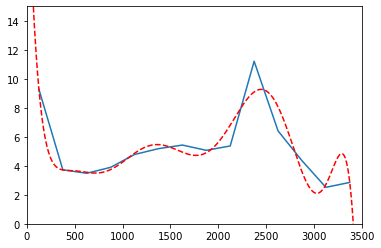

In [33]:
# Variables for the different error models
jumps = [5, 20, 5, 250]
starts = [0, 0, 0, 0]
ends = [65, 280, 60, 3500]

functions = [objective_2f, objective_3f, objective_4f, objective_5f, objective_6f, objective_7f, objective_8f, objective_9f, objective_10f]
error_model_names = ['height_distance', 'height_2d', 'pointcloud_distance', 'pointcloud_n_points']
model_columns = ['distance_height', 'height_image', 'distance_pointcloud', 'n_points']
class_names = ['Car', 'Cyclist', 'Pedestrian']

# Loop over error models
for error_model_name, model_column, jump, start, end in zip(error_model_names, model_columns,jumps, starts, ends):
    # Loop over class names
    for class_name in class_names:
        
        approximate_distance_column = 'distance_' + error_model_name.split("_")[0]
        
        df_train_class = df_train[df_train['type'] == class_name]
    
        # Calculate deciles
        MPointE_points = []
        for point in range(start, end, jump):
            MPointE_point = df_train_class[(point < df_train_class[model_column]) & \
                                               (df_train_class[model_column] < point+jump)].apply(lambda row: row['distance']-row[approximate_distance_column],
                                                                                                        axis=1).quantile(q=[0.1,0.9])
            MPointE_points.append(MPointE_point)
        q_0_1 = list(map(lambda x: x.get(0.1), MPointE_points))
        q_0_9 = list(map(lambda x: x.get(0.9), MPointE_points))

        # Create axis
        Y = [x1 - x2 for (x1, x2) in zip(q_0_9, q_0_1)]
        X = (np.array(list(range(start,end,jump)))+jump/2).tolist()
        
        # Only one function with training data is to be created, so the validation dataset is not necessary
        start_ = int(start + jump/2)
        end_ = int(end - jump/2)
        MPointE_points_ = []
        for point in range(start_, end_, jump):
            MPointE_point = df_train_class[(point < df_train_class[model_column]) & \
                                               (df_train_class[model_column] < point+jump)].apply(lambda row: row['distance']-row[approximate_distance_column],
                                                                                                        axis=1).quantile(q=[0.1,0.9])
            MPointE_points_.append(MPointE_point)
        q_0_1_ = list(map(lambda x: x.get(0.1), MPointE_points_))
        q_0_9_ = list(map(lambda x: x.get(0.9), MPointE_points_))
        Y_val = [x1 - x2 for (x1, x2) in zip(q_0_9_, q_0_1_)]
        X_val = (np.array(list(range(start_,end_,jump)))+jump/2).tolist()
        
        
        popt_functions = list(map(lambda function: curve_fit(function, X, Y,maxfev = 1000000)[0], functions))
        mses_class_model_error = list(map(lambda function, popt: mean_squared_error(Y_val, list(map(lambda x: function(x, *popt), X_val))), functions, popt_functions))
        
        min_mse = min(mses_class_model_error)
        id_function = mses_class_model_error.index(min_mse)
        function = functions[id_function]
        popt = popt_functions[id_function]
        
        X_line = (np.array(list(range(start,end,1)))+1/2).tolist()
        
        print(error_model_name)
        print(class_name)
        print(function)
        print(popt)
        print(mses_class_model_error)
        plt.plot(X, Y)
        plt.plot(X_line, list(map(lambda x: function(x, *popt), X_line)), '--', color='red')
        plt.xlim((start,end))
        plt.ylim((0,15))
        plt.show()

Reduce overfitting in the first and last values

height_distance
Car
<function objective_7f at 0x7ff77600e1e0>
[ 5.98392787e-10 -1.56696981e-07  1.66293941e-05 -9.09624652e-04
  2.67741201e-02 -3.98084747e-01  2.56542996e+00 -5.84653968e-01]
[1.0593778043378481, 0.598633339273621, 0.7546769245117477, 0.6988292143672171, 0.37168686887274, 0.22069182487518488, 0.921537867223368, 1.6450819899109874, 72.70065721088879]


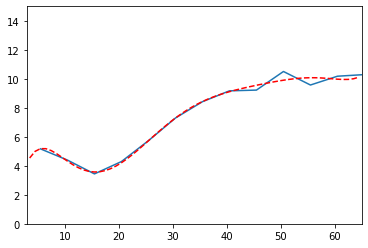

height_distance
Cyclist
<function objective_2f at 0x7ff776467a60>
[ 2.10860217e-03 -3.02038013e-02  3.30876800e+00]
[0.6501311781926473, 0.8039092758173474, 1.2095854116849996, 1.5738262809765664, 0.9493247630001489, 2.231173944937113, 20.266512040005324, 11.790600715331463, 10.36316923028575]


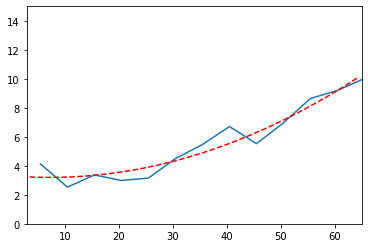

height_distance
Pedestrian
<function objective_6f at 0x7ff77600e268>
[-9.52494488e-09  1.86194654e-06 -1.29953164e-04  3.73031511e-03
 -3.45949445e-02  4.21000624e-02  2.84518231e+00]
[0.842383559675836, 1.0032784401258221, 0.8261757216411875, 0.5643387675051176, 0.25237197561390473, 0.2752822411010818, 3.265005704404023, 55.93431448899925, 41.093627388737104]


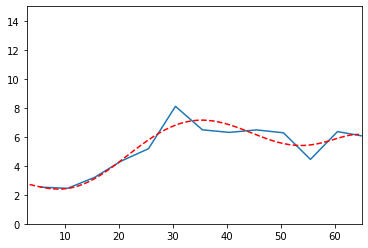

height_2d
Car
<function objective_6f at 0x7ff77600e268>
[-3.09293713e-12  2.84986571e-09 -1.01532872e-06  1.72016829e-04
 -1.33523665e-02  3.28335499e-01  7.52713434e+00]
[3.4838858925649743, 0.8729932641993282, 0.8717801620802018, 0.8510337357513739, 0.7184855715080943, 0.9082818540411386, 1.3551669114559526, 35.3838237831584, 34.629347844500224]


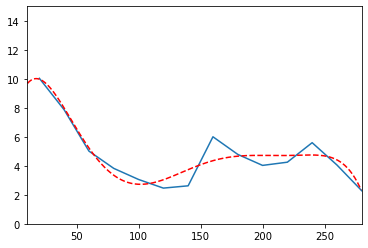

height_2d
Cyclist
<function objective_4f at 0x7ff7764678c8>
[ 8.47000009e-09 -7.78577918e-06  2.30025516e-03 -2.63072353e-01
  1.28695128e+01]
[2.1600396143894454, 0.7306488126642114, 0.539929852462812, 0.6172484702848154, 0.8786058667903537, 0.954007723784414, 2.970628344571557, 26.588428479881923, 86.22354187054201]


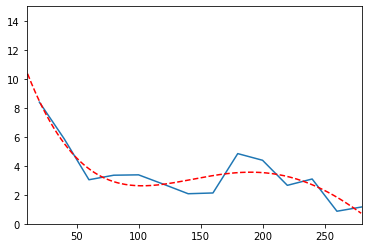

height_2d
Pedestrian
<function objective_5f at 0x7ff776467f28>
[ 2.43171768e-10 -1.91830831e-07  5.49614509e-05 -6.71570657e-03
  2.90152706e-01  2.75605106e+00]
[0.4655935537828703, 0.4867870964387706, 0.3245986793157609, 0.3168474808630169, 0.4437117335743015, 2.752370232197973, 4.135345244283633, 13.272320422805773, 15.860246514356342]


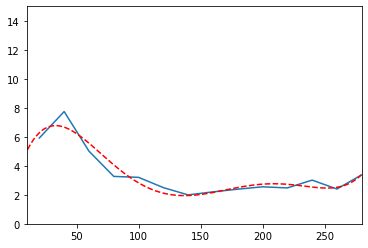

pointcloud_distance
Car
<function objective_4f at 0x7ff7764678c8>
[ 3.99033953e-06 -4.16159375e-04  1.40148944e-02 -7.26463102e-02
  4.13518840e+00]
[2.6663535319974794, 2.7925220022267805, 2.104333818487751, 3.7309151797367046, 11.118701251216248, 12.24037804039102, 9.76238341050384, 3.9126075003519243, 34.52410044179092]


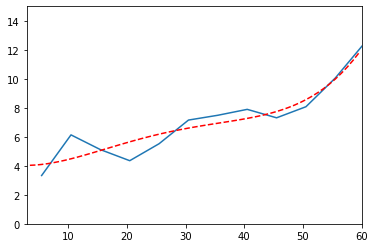

pointcloud_distance
Cyclist
<function objective_2f at 0x7ff776467a60>
[-0.00340938  0.51141084 -1.16112574]
[41.56677580035546, 49.76473531597973, 63.264957329203654, 111.23472971154902, 181.33731684710696, 326.77533169819276, 429.9168134839992, 390.05780248744065, 1480.3883907179797]


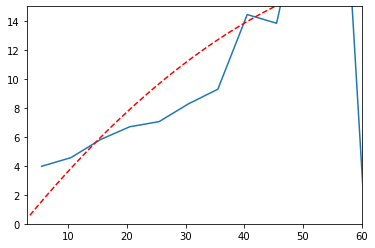

pointcloud_distance
Pedestrian
<function objective_2f at 0x7ff776467a60>
[ 0.01327938 -0.32668397  6.73133745]
[6.4700888425452145, 12.585715454764616, 16.369110395168143, 18.117547124173104, 14.731135399107634, 38.71523120416022, 49.196073984249196, 322.1815880390646, 1749.4297468862637]


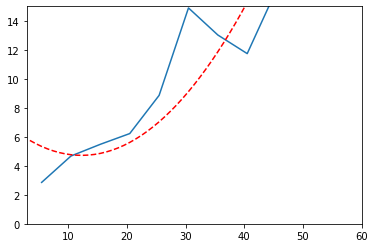

pointcloud_n_points
Car
<function objective_5f at 0x7ff776467f28>
[ 1.11949523e-15 -9.85006510e-12  2.87567548e-08 -3.09069080e-05
  9.18465598e-03  5.06133426e+00]
[5.580020261946922, 3.235144935026029, 2.297479469437493, 2.02011353297495, 4.111600145781987, 7.005887216888731, 5.9461925767760375, 93.24286879613486, 152.10670692557082]


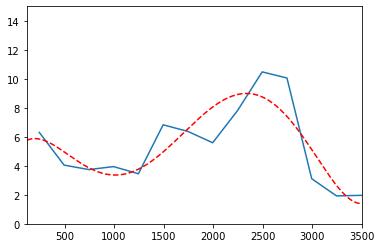

pointcloud_n_points
Cyclist
<function objective_3f at 0x7ff799b1e378>
[-4.94408915e-10  3.24127423e-06 -7.42889093e-03  9.32095398e+00]
[1.0341423952850863, 0.43324225756828316, 1.0355283107841478, 1.328286213601489, 1.8294012043897026, 1.8401646072042697, 7.9195148461659945, 36.78797622560844, 54.95604436923395]


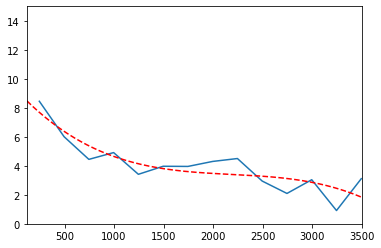

pointcloud_n_points
Pedestrian
<function objective_3f at 0x7ff799b1e378>
[-1.68578231e-09  8.01205031e-06 -8.93509826e-03  6.43583260e+00]
[6.9542583996998495, 3.412179081849804, 3.628942109350114, 5.334678841497699, 5.441707170895353, 3.4729615696072216, 27.67296315482521, 129.29032850474167, 107.04534642366492]


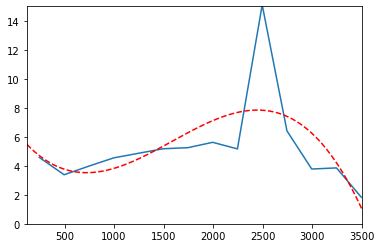

In [34]:
dict_models = {'height_distance':{'Car':None,'Cyclist':None,'Pedestrian':None},
               'height_2d':{'Car':None,'Cyclist':None,'Pedestrian':None},
               'pointcloud_distance':{'Car':None,'Cyclist':None,'Pedestrian':None},
               'pointcloud_n_points':{'Car':None,'Cyclist':None,'Pedestrian':None}}

# Variables for the different error models
jumps = [5, 20, 5, 250]
starts = [3, 10, 3, 120]
ends = [65, 280, 60, 3500]

functions = [objective_2f, objective_3f, objective_4f, objective_5f, objective_6f, objective_7f, objective_8f, objective_9f, objective_10f]
error_model_names = ['height_distance', 'height_2d', 'pointcloud_distance', 'pointcloud_n_points']
model_columns = ['distance_height', 'height_image', 'distance_pointcloud', 'n_points']
class_names = ['Car', 'Cyclist', 'Pedestrian']

# Loop over error models
for error_model_name, model_column, jump, start, end in zip(error_model_names, model_columns,jumps, starts, ends):
    # Loop over class names
    for class_name in class_names:
        
        approximate_distance_column = 'distance_' + error_model_name.split("_")[0]
        
        df_train_class = df_train[df_train['type'] == class_name]
    
        # Calculate deciles
        MPointE_points = []
        for point in range(start, end, jump):
            MPointE_point = df_train_class[(point < df_train_class[model_column]) & \
                                               (df_train_class[model_column] < point+jump)].apply(lambda row: row['distance']-row[approximate_distance_column],
                                                                                                        axis=1).quantile(q=[0.1,0.9])
            MPointE_points.append(MPointE_point)
        q_0_1 = list(map(lambda x: x.get(0.1), MPointE_points))
        q_0_9 = list(map(lambda x: x.get(0.9), MPointE_points))

        # Create axis
        Y = [x1 - x2 for (x1, x2) in zip(q_0_9, q_0_1)]
        X = (np.array(list(range(start,end,jump)))+jump/2).tolist()
        
        # Only one function with training data is to be created, so the validation dataset is not necessary
        start_ = int(start - jump/2)
        end_ = int(end + jump/2)
        MPointE_points_ = []
        for point in range(start_, end_, jump):
            MPointE_point = df_train_class[(point < df_train_class[model_column]) & \
                                               (df_train_class[model_column] < point+jump)].apply(lambda row: row['distance']-row[approximate_distance_column],
                                                                                                        axis=1).quantile(q=[0.1,0.9])
            MPointE_points_.append(MPointE_point)
        q_0_1_ = list(map(lambda x: x.get(0.1), MPointE_points_))
        q_0_9_ = list(map(lambda x: x.get(0.9), MPointE_points_))
        Y_val = [x1 - x2 for (x1, x2) in zip(q_0_9_, q_0_1_)]
        X_val = (np.array(list(range(start_,end_,jump)))+jump/2).tolist()
        
        
        popt_functions = list(map(lambda function: curve_fit(function, X, Y,maxfev = 1000000)[0], functions))
        mses_class_model_error = list(map(lambda function, popt: mean_squared_error(Y_val, list(map(lambda x: function(x, *popt), X_val))), functions, popt_functions))
        
        min_mse = min(mses_class_model_error)
        id_function = mses_class_model_error.index(min_mse)
        function = functions[id_function]
        popt = popt_functions[id_function]
        
        X_line = (np.array(list(range(start,end,1)))+1/2).tolist()
        
        dict_models[error_model_name][class_name] = Regression_model(function, popt)
        
        print(error_model_name)
        print(class_name)
        print(function)
        print(popt)
        print(mses_class_model_error)
        plt.plot(X, Y)
        plt.plot(X_line, list(map(lambda x: function(x, *popt), X_line)), '--', color='red')
        plt.xlim((start,end))
        plt.ylim((0,15))
        plt.show()

In [35]:
dict_models

{'height_distance': {'Car': <__main__.Regression_model at 0x7ff797ec6080>,
  'Cyclist': <__main__.Regression_model at 0x7ff797e52ac8>,
  'Pedestrian': <__main__.Regression_model at 0x7ff7ba195358>},
 'height_2d': {'Car': <__main__.Regression_model at 0x7ff797e68208>,
  'Cyclist': <__main__.Regression_model at 0x7ff79446dba8>,
  'Pedestrian': <__main__.Regression_model at 0x7ff797e68588>},
 'pointcloud_distance': {'Car': <__main__.Regression_model at 0x7ff794400240>,
  'Cyclist': <__main__.Regression_model at 0x7ff7944005c0>,
  'Pedestrian': <__main__.Regression_model at 0x7ff79440a400>},
 'pointcloud_n_points': {'Car': <__main__.Regression_model at 0x7ff775def550>,
  'Cyclist': <__main__.Regression_model at 0x7ff797d4c0f0>,
  'Pedestrian': <__main__.Regression_model at 0x7ff797d20160>}}

In [36]:
def get_error_model(dict_models):
    error_model = Regression_model_error(Regression_model_class(dict_models['height_distance']['Car'],
                                                             dict_models['height_distance']['Cyclist'],
                                                             dict_models['height_distance']['Pedestrian']),
                                      Regression_model_class(dict_models['height_2d']['Car'],
                                                             dict_models['height_2d']['Cyclist'],
                                                             dict_models['height_2d']['Pedestrian']),
                                      Regression_model_class(dict_models['pointcloud_distance']['Car'],
                                                             dict_models['pointcloud_distance']['Car'],
                                                             dict_models['pointcloud_distance']['Car']),
                                      Regression_model_class(dict_models['pointcloud_n_points']['Car'],
                                                             dict_models['pointcloud_n_points']['Cyclist'],
                                                             dict_models['pointcloud_n_points']['Pedestrian']))
    return error_model

In [37]:
error_model = get_error_model(dict_models)

In [38]:
print(error_model)

height_distance: {car: {function = <function objective_7f at 0x7ff77600e1e0>, variables = [ 5.98392787e-10 -1.56696981e-07  1.66293941e-05 -9.09624652e-04
  2.67741201e-02 -3.98084747e-01  2.56542996e+00 -5.84653968e-01]},
pedestrian: {function = <function objective_2f at 0x7ff776467a60>, variables = [ 2.10860217e-03 -3.02038013e-02  3.30876800e+00]},
cyclist: {function = <function objective_6f at 0x7ff77600e268>, variables = [-9.52494488e-09  1.86194654e-06 -1.29953164e-04  3.73031511e-03
 -3.45949445e-02  4.21000624e-02  2.84518231e+00]}},
height_2d: {car: {function = <function objective_6f at 0x7ff77600e268>, variables = [-3.09293713e-12  2.84986571e-09 -1.01532872e-06  1.72016829e-04
 -1.33523665e-02  3.28335499e-01  7.52713434e+00]},
pedestrian: {function = <function objective_4f at 0x7ff7764678c8>, variables = [ 8.47000009e-09 -7.78577918e-06  2.30025516e-03 -2.63072353e-01
  1.28695128e+01]},
cyclist: {function = <function objective_5f at 0x7ff776467f28>, variables = [ 2.4317176

In [39]:
#with open('error_model.pkl', 'wb') as f:
    #f.write(pickle.dumps(error_model))

# Validate ensemble method

## Usage of the new method

In [40]:
def ajust_distance(error_model, height_distance, height_2d, pointcloud_distance, pointcloud_n_points, class_name):
    # Obtain regression models based on the object type
    if class_name == 'Car':
        height_distance_model = error_model.height_distance.car
        height_2d_model = error_model.height_2d.car
        pointcloud_distance_model = error_model.pointcloud_distance.car
        pointcloud_n_points_model = error_model.pointcloud_n_points.car
    elif class_name == 'Cyclist':
        height_distance_model = error_model.height_distance.cyclist
        height_2d_model = error_model.height_2d.cyclist
        pointcloud_distance_model = error_model.pointcloud_distance.cyclist
        pointcloud_n_points_model = error_model.pointcloud_n_points.cyclist
    elif class_name == 'Pedestrian':
        height_distance_model = error_model.height_distance.pedestrian
        height_2d_model = error_model.height_2d.pedestrian
        pointcloud_distance_model = error_model.pointcloud_distance.pedestrian
        pointcloud_n_points_model = error_model.pointcloud_n_points.pedestrian
    else:
        raise ValueError("Type must be Car, Pedestrian or Cyclist")   
    # Obtain an approximate error based on different metrics
    height_distance_error = height_distance_model.function(height_distance, *height_distance_model.variables)
    height_2d_error = height_2d_model.function(height_2d, *height_2d_model.variables)
    pointcloud_distance_error = pointcloud_distance_model.function(pointcloud_distance, *pointcloud_distance_model.variables)
    pointcloud_n_points_error = pointcloud_n_points_model.function(pointcloud_n_points, *pointcloud_n_points_model.variables)
    # Obtain final distance to use
    sum_error = height_distance_error + height_2d_error + pointcloud_distance_error + pointcloud_n_points_error
    distance = (1 - (height_distance_error + height_2d_error)/sum_error) * height_distance +\
               (1 - (pointcloud_distance_error + pointcloud_n_points_error)/sum_error) * pointcloud_distance
    return distance

In [41]:
ajust_distance(error_model, 30, 40, 20, 5, 'Car')

24.141421847322846

In [42]:
df_train['distance_ensemble'] = df_train.apply(lambda row: ajust_distance(error_model,
                                                                          row['distance_height'],
                                                                          row['height_image'],
                                                                          row['distance_pointcloud'],
                                                                          row['n_points'],
                                                                          row['type']) if row['distance_pointcloud'] != None else row['distance_height'], axis=1)
df_val['distance_ensemble'] = df_val.apply(lambda row: ajust_distance(error_model,
                                                                      row['distance_height'],
                                                                      row['height_image'],
                                                                      row['distance_pointcloud'],
                                                                      row['n_points'],
                                                                      row['type']) if row['distance_pointcloud'] != None else row['distance_height'], axis=1)

In [43]:
df_train

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,height,width,length,x,y,z,ry,distance,height_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom,distance_height,distance_pointcloud,error_distance_height,error_distance_pointcloud,n_points,distance_ensemble
0,0,0,Pedestrian,0.00,0.0,-0.20,712.40,143.00,810.73,307.92,1.89,0.48,1.20,1.84,1.47,8.41,0.01,8.733533,164.92,98.33,0.21,False,False,8.597865,12.379818,0.135668,-3.646285,1463,10.246847
1,1,0,Car,0.00,0.0,1.85,387.63,181.54,423.81,203.12,1.67,1.87,3.69,-16.53,2.39,58.49,1.57,60.827897,21.58,36.18,-0.28,False,False,53.316196,58.928456,7.511702,1.899441,12,56.375720
2,1,1,Cyclist,0.00,3.0,-1.65,676.60,163.95,688.98,193.93,1.86,0.60,2.02,4.59,1.32,45.84,-1.55,46.088134,29.98,12.38,0.10,False,False,43.396508,44.248675,2.691626,1.839459,27,43.813001
3,2,0,Car,0.00,0.0,-1.67,657.39,190.13,700.07,223.39,1.41,1.58,4.36,3.18,2.27,34.38,-1.58,34.601296,33.26,42.68,0.09,False,False,36.825652,38.057486,-2.224356,-3.456190,111,37.536654
4,3,0,Car,0.00,0.0,1.55,614.24,181.78,727.31,284.77,1.57,1.73,4.15,1.00,1.75,13.22,1.62,13.372767,102.99,113.07,0.07,False,False,13.570701,15.194321,-0.197934,-1.821554,1016,14.275604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27309,5983,7,Car,0.00,2.0,-1.71,678.38,179.02,765.40,234.72,1.32,1.70,4.04,2.84,1.50,19.37,-1.57,19.634472,55.70,87.02,0.14,False,False,23.759745,24.190668,-4.125273,-4.556195,115,23.966972
27310,5983,8,Car,0.00,2.0,-1.72,668.22,167.79,726.04,215.88,1.56,1.48,3.36,2.95,1.42,25.30,-1.61,25.510956,48.09,57.82,0.11,False,False,26.950301,43.970196,-1.439345,-18.459240,98,35.388411
27311,5983,9,Car,0.00,1.0,-1.66,640.25,174.03,671.68,198.24,1.38,1.55,3.60,2.70,1.47,43.39,-1.60,43.498770,24.21,31.43,0.06,False,False,48.262606,45.390958,-4.763836,-1.892188,40,46.544693
27312,5983,10,Car,0.77,3.0,2.27,0.00,196.98,95.57,298.45,1.35,1.59,3.41,-9.21,1.73,10.06,1.55,13.748476,101.47,95.57,-0.72,True,False,15.359191,9.317900,-1.610715,4.430576,406,12.985632


## Validate using KITTI difficulties

In [44]:
def define_difficulty(row):
    height = row['bottom'] - row['top']
    occlusion = row['occluded']
    truncation = row['truncated']
    if(height >= 40 and occlusion == 0 and truncation <= 0.15):
        return 0
    elif(height >= 25 and occlusion <= 1 and truncation <= 0.3):
        return 1
    elif(height >= 25 and occlusion <= 2 and truncation <= 0.5):
        return 2
    else:
        return 3

In [45]:
df_train['difficulty'] = df_train.apply(lambda row: define_difficulty(row), axis=1)
df_val['difficulty'] = df_val.apply(lambda row: define_difficulty(row), axis=1)

In [46]:
df_val

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,height,width,length,x,y,z,ry,distance,height_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom,distance_height,distance_pointcloud,error_distance_height,error_distance_pointcloud,n_points,distance_ensemble,difficulty
0,5984,0,Car,0.0,1.0,3.10,431.50,171.26,514.83,204.10,1.49,1.46,3.84,-6.60,1.44,34.58,2.91,35.233649,32.84,83.33,-0.19,False,False,37.223531,38.266789,-1.989883,-3.033141,228,37.824531,1
1,5984,1,Pedestrian,0.0,1.0,2.84,759.60,163.84,772.27,193.28,1.86,0.57,1.08,9.91,1.30,46.20,3.05,47.268786,29.44,12.67,0.21,False,False,43.724626,46.418030,3.544160,0.850756,27,44.889532,1
2,5984,2,Car,0.0,0.0,1.22,699.42,157.64,744.58,190.94,2.21,1.76,4.11,7.73,1.22,50.24,1.37,50.845835,33.30,45.16,0.15,False,False,36.788248,51.989090,14.057587,-1.143255,50,45.141565,1
3,5984,3,Car,0.0,1.0,-2.01,729.47,164.21,774.61,189.74,1.75,1.57,4.07,10.11,1.18,51.72,-1.82,52.712075,25.53,45.14,0.19,False,False,46.111278,53.180900,6.600798,-0.468825,18,50.151456,1
4,5984,4,Car,0.0,0.0,-2.05,767.91,164.74,823.24,187.41,1.54,1.71,5.03,13.25,1.02,51.91,-1.80,53.584055,22.67,55.33,0.25,False,False,51.081492,54.453847,2.502564,-0.869791,29,53.004196,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6696,7480,9,Car,0.0,2.0,-0.33,749.78,170.88,917.51,243.48,1.77,1.69,3.82,5.72,1.75,18.85,-0.04,19.776334,72.60,167.73,0.29,False,False,18.821832,23.025045,0.954502,-3.248711,449,20.549721,2
6697,7480,10,Car,0.0,1.0,-2.90,344.07,180.05,479.10,224.15,1.49,1.59,4.44,-7.12,1.78,26.03,3.12,27.044846,44.10,135.03,-0.26,False,False,29.010171,29.638311,-1.965325,-2.593465,380,29.351262,1
6698,7480,11,Car,0.0,2.0,-2.91,382.70,179.71,495.48,219.10,1.48,1.63,4.10,-6.79,1.78,28.78,-3.14,29.623654,39.39,112.78,-0.23,False,False,31.921166,34.013135,-2.297512,-4.389481,56,33.094471,2
6699,7480,12,Car,0.0,0.0,-1.69,631.71,179.85,678.40,214.37,1.41,1.56,4.08,1.90,1.74,31.98,-1.63,32.083610,34.52,46.69,0.06,False,False,35.686282,34.715410,-3.602672,-2.631800,121,35.127189,1


In [47]:
def evaluate(distance_column):
    difficulties = [0, 1, 2]                       
    classes = ["Car","Cyclist","Pedestrian"]
    text_difficulties = ["Easy", "Moderate", "Hard"]

    def mse(frame):
        df_frame = df_val[df_val['frame'] == frame]
        bbs_distance_gt = df_frame['distance'].tolist()
        bbs_distance_approx = df_frame[distance_column].tolist()
        mse_value = mean_squared_error(bbs_distance_gt, bbs_distance_approx)

        return mse_value

    print("################################", end="\n\n")

    # Iterate over difficulties
    for difficulty, text_difficulty in zip(difficulties, text_difficulties):
        # Iterate over classes
        for class_name in classes:                  
            df_difficulty = df_val[(df_val['difficulty'] <= difficulty) & (df_val['type'] == class_name)]
            #mse_by_frame = df_difficulty['frame'].unique()
            start_time = time.time()
            #mse_by_frame = list(map(mse, mse_by_frame))
            mse = mean_squared_error(df_difficulty['distance'].tolist(),
                                     df_difficulty[distance_column].tolist())

            #mse_by_frame_without_none = list(filter(partial(is_not, None), mse_by_frame))

            #mean_mse = statistics.mean(mse_by_frame_without_none)
            print("--- %s seconds to calculate MSE, %s difficulty, %s class  ---" % (time.time() - start_time, text_difficulty, class_name))

            print("\nMean of all MSE by frame, %s difficulty, %s class = %s\n" % (text_difficulty, class_name, mse))

        print("################################", end="\n\n")

In [48]:
evaluate('distance_ensemble')

################################

--- 0.00038504600524902344 seconds to calculate MSE, Easy difficulty, Car class  ---

Mean of all MSE by frame, Easy difficulty, Car class = 3.3888112721700727

--- 0.00023126602172851562 seconds to calculate MSE, Easy difficulty, Cyclist class  ---

Mean of all MSE by frame, Easy difficulty, Cyclist class = 1.8198540799029956

--- 0.00035643577575683594 seconds to calculate MSE, Easy difficulty, Pedestrian class  ---

Mean of all MSE by frame, Easy difficulty, Pedestrian class = 1.9500263298102842

################################

--- 0.00045418739318847656 seconds to calculate MSE, Moderate difficulty, Car class  ---

Mean of all MSE by frame, Moderate difficulty, Car class = 7.216861224930235

--- 0.0004105567932128906 seconds to calculate MSE, Moderate difficulty, Cyclist class  ---

Mean of all MSE by frame, Moderate difficulty, Cyclist class = 4.675600381256697

--- 0.00027561187744140625 seconds to calculate MSE, Moderate difficulty, Pedestrian

# Use of the square error in the ensemble model 

In [49]:
def ajust_distance2(error_model, height_distance, height_2d, pointcloud_distance, pointcloud_n_points, class_name):
    # Obtain regression models based on the object type
    if class_name == 'Car':
        height_distance_model = error_model.height_distance.car
        height_2d_model = error_model.height_2d.car
        pointcloud_distance_model = error_model.pointcloud_distance.car
        pointcloud_n_points_model = error_model.pointcloud_n_points.car
    elif class_name == 'Cyclist':
        height_distance_model = error_model.height_distance.cyclist
        height_2d_model = error_model.height_2d.cyclist
        pointcloud_distance_model = error_model.pointcloud_distance.cyclist
        pointcloud_n_points_model = error_model.pointcloud_n_points.cyclist
    elif class_name == 'Pedestrian':
        height_distance_model = error_model.height_distance.pedestrian
        height_2d_model = error_model.height_2d.pedestrian
        pointcloud_distance_model = error_model.pointcloud_distance.pedestrian
        pointcloud_n_points_model = error_model.pointcloud_n_points.pedestrian
    else:
        raise ValueError("Type must be Car, Pedestrian or Cyclist")   
    # Obtain an approximate error based on different metrics
    height_distance_error = height_distance_model.function(height_distance, *height_distance_model.variables) ** 2
    height_2d_error = height_2d_model.function(height_2d, *height_2d_model.variables) ** 2
    pointcloud_distance_error = pointcloud_distance_model.function(pointcloud_distance, *pointcloud_distance_model.variables) ** 2
    pointcloud_n_points_error = pointcloud_n_points_model.function(pointcloud_n_points, *pointcloud_n_points_model.variables) ** 2
    # Obtain final distance to use
    sum_error = height_distance_error + height_2d_error + pointcloud_distance_error + pointcloud_n_points_error
    distance = (1 - (height_distance_error + height_2d_error)/sum_error) * height_distance +\
               (1 - (pointcloud_distance_error + pointcloud_n_points_error)/sum_error) * pointcloud_distance
    return distance

In [50]:
df_train['distance_ensemble2'] = df_train.apply(lambda row: ajust_distance2(error_model,
                                                                          row['distance_height'],
                                                                          row['height_image'],
                                                                          row['distance_pointcloud'],
                                                                          row['n_points'],
                                                                          row['type']) if row['distance_pointcloud'] != None else row['distance_height'], axis=1)
df_val['distance_ensemble2'] = df_val.apply(lambda row: ajust_distance2(error_model,
                                                                      row['distance_height'],
                                                                      row['height_image'],
                                                                      row['distance_pointcloud'],
                                                                      row['n_points'],
                                                                      row['type']) if row['distance_pointcloud'] != None else row['distance_height'], axis=1)

In [51]:
evaluate('distance_ensemble2')

################################

--- 0.00045013427734375 seconds to calculate MSE, Easy difficulty, Car class  ---

Mean of all MSE by frame, Easy difficulty, Car class = 3.2986651308411186

--- 0.0002429485321044922 seconds to calculate MSE, Easy difficulty, Cyclist class  ---

Mean of all MSE by frame, Easy difficulty, Cyclist class = 1.71219121105739

--- 0.00027179718017578125 seconds to calculate MSE, Easy difficulty, Pedestrian class  ---

Mean of all MSE by frame, Easy difficulty, Pedestrian class = 1.8537843300000054

################################

--- 0.00045871734619140625 seconds to calculate MSE, Moderate difficulty, Car class  ---

Mean of all MSE by frame, Moderate difficulty, Car class = 7.55568259459465

--- 0.0003437995910644531 seconds to calculate MSE, Moderate difficulty, Cyclist class  ---

Mean of all MSE by frame, Moderate difficulty, Cyclist class = 4.135205227233875

--- 0.0002789497375488281 seconds to calculate MSE, Moderate difficulty, Pedestrian class  

# Using centiles instead of deciles to create the error function

height_distance
Car
<function objective_6f at 0x7ff77600e268>
[-1.62474016e-08  3.59747637e-06 -3.07431611e-04  1.23736293e-02
 -2.26145819e-01  1.74878609e+00  4.24660243e+00]
[5.032636430189489, 0.9657273620766882, 1.258382570473459, 1.0367113779863042, 0.5845693609104752, 4.621739949251877, 13.520542960092229, 66.79417636507532, 27.696997243442013]


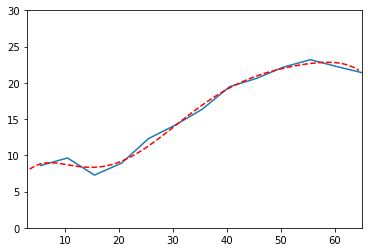

height_distance
Cyclist
<function objective_3f at 0x7ff799b1e378>
[ 4.99874253e-05 -8.36265687e-03  4.39954656e-01  2.50014906e+00]
[1.9316258570773868, 1.6015182568572623, 2.897595993291794, 4.371900718220206, 2.093350436596076, 5.000793431476389, 24.323415191193483, 27.21018503527651, 542.5368277405844]


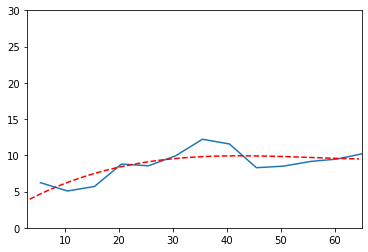

height_distance
Pedestrian
<function objective_3f at 0x7ff799b1e378>
[ 8.17585155e-05 -1.48830493e-02  7.10407554e-01 -7.07085438e-02]
[1.3145441052255886, 1.2883989011414094, 1.766363076535757, 2.2141058388976655, 1.6176819666464664, 1.8902762774818203, 3.3757305633952712, 19.59136715526332, 9.733391860642433]


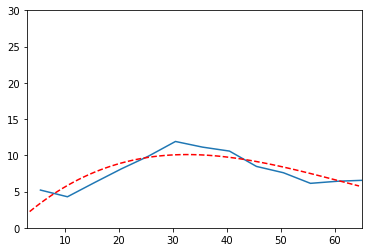

height_2d
Car
<function objective_6f at 0x7ff77600e268>
[-4.47293901e-12  3.89698307e-09 -1.26335182e-06  1.79293477e-04
 -8.63056536e-03 -2.66031446e-01  3.20590521e+01]
[8.762212642583853, 3.0866615057095936, 5.048772830554471, 5.717336251823122, 2.8083013466559392, 4.053822125521533, 19.456090626875476, 17.99713507480943, 34.304426340782946]


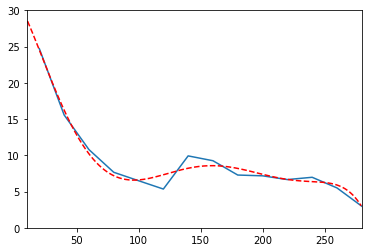

height_2d
Cyclist
<function objective_6f at 0x7ff77600e268>
[ 2.78849909e-12 -1.98071367e-09  4.49275212e-07 -2.55864867e-05
 -2.49884249e-03  1.93519936e-01  8.36739434e+00]
[2.277144559062403, 1.8052474855349951, 1.7033051477331933, 1.4629924200250997, 1.30964856581576, 2.246390063290042, 5.061524328598671, 11.978322769715113, 37.48426948732761]


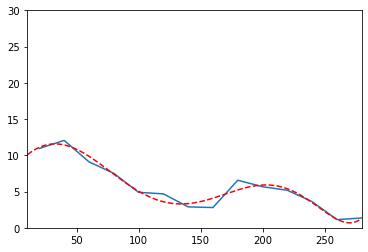

height_2d
Pedestrian
<function objective_7f at 0x7ff77600e1e0>
[ 5.32633100e-15 -7.16687514e-12  4.08376405e-09 -1.25741005e-06
  2.19366101e-04 -2.05238367e-02  8.30141401e-01 -1.36575057e-03]
[2.79578855816727, 3.032801959263085, 1.391396822515903, 0.29484057913601247, 0.1316294812809707, 0.1084229279969826, 2.24398390589788, 2.329114755352743, 1.5167056009631632]


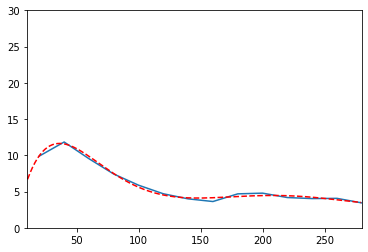

pointcloud_distance
Car
<function objective_2f at 0x7ff776467a60>
[ 3.54062984e-03 -2.74372189e-03  3.09996956e+01]
[11.775515470683917, 12.521142610820059, 12.968629978826113, 29.825640725888356, 25.934952326739037, 335.29683412777325, 704.2625174548136, 692.5334350119527, 3093.6382057307324]


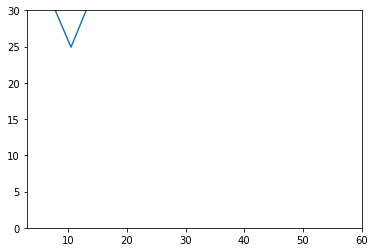

pointcloud_distance
Cyclist
<function objective_4f at 0x7ff7764678c8>
[-6.76126878e-05  7.86872745e-03 -2.98814711e-01  4.64835626e+00
 -9.47796871e+00]
[52.940874409797125, 46.902511216776176, 28.99205519841229, 54.09726560585916, 109.04604536858068, 160.4943122459273, 421.4460851074237, 660.4478429963857, 1968.9046789562503]


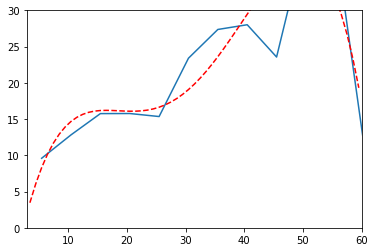

pointcloud_distance
Pedestrian
<function objective_2f at 0x7ff776467a60>
[9.90867499e-04 4.85602264e-01 1.06837328e+01]
[9.378249497660583, 11.079486725979136, 14.210577018416748, 11.595815162491991, 9.708611579017024, 60.75551349204034, 27.586064011920136, 975.9880818463521, 61287.38530741675]


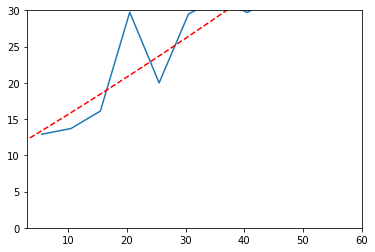

pointcloud_n_points
Car
<function objective_8f at 0x7ff77600e378>
[ 8.98730831e-25 -1.46344570e-20  9.93386759e-17 -3.63942982e-13
  7.80045990e-10 -9.97352998e-07  7.51484001e-04 -3.17708873e-01
  7.59170020e+01]
[48.25213190677554, 18.991496138286713, 8.966464810198147, 7.665471641478594, 6.31150309572358, 3.665226413418398, 1.361143989656248, 1.9226533338308223, 559.77426789915]


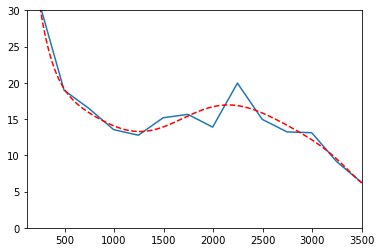

pointcloud_n_points
Cyclist
<function objective_6f at 0x7ff77600e268>
[-4.30865216e-21 -1.19101308e-16  3.83917373e-12 -2.50528567e-08
  6.41295278e-05 -7.17191799e-02  3.76203313e+01]
[13.440434122134628, 7.162335238178691, 4.963237609648405, 4.632916178897656, 4.623395995834893, 5.892889458456299, 7.907187540384653, 122.24929753404197, 129.4181758890533]


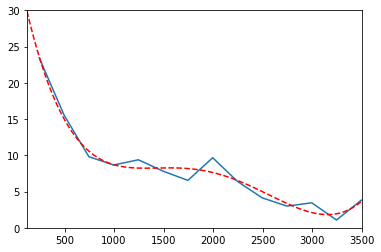

pointcloud_n_points
Pedestrian
<function objective_8f at 0x7ff77600e378>
[ 7.77232048e-25 -1.23405405e-20  8.14001213e-17 -2.87065968e-13
  5.81522484e-10 -6.82762803e-07  4.57429002e-04 -1.71478057e-01
  4.10607517e+01]
[69.17246657061142, 39.40214103170056, 26.382411985285884, 34.37149567761407, 34.51131008680679, 27.22595950046307, 21.643635721732355, 63.606330791566535, 623.48110906452]


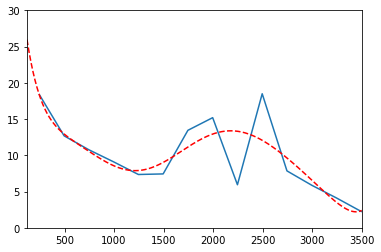

In [52]:
dict_models = {'height_distance':{'Car':None,'Cyclist':None,'Pedestrian':None},
               'height_2d':{'Car':None,'Cyclist':None,'Pedestrian':None},
               'pointcloud_distance':{'Car':None,'Cyclist':None,'Pedestrian':None},
               'pointcloud_n_points':{'Car':None,'Cyclist':None,'Pedestrian':None}}

# Variables for the different error models
jumps = [5, 20, 5, 250]
starts = [3, 10, 3, 120]
ends = [65, 280, 60, 3500]

functions = [objective_2f, objective_3f, objective_4f, objective_5f, objective_6f, objective_7f, objective_8f, objective_9f, objective_10f]
error_model_names = ['height_distance', 'height_2d', 'pointcloud_distance', 'pointcloud_n_points']
model_columns = ['distance_height', 'height_image', 'distance_pointcloud', 'n_points']
class_names = ['Car', 'Cyclist', 'Pedestrian']

# Loop over error models
for error_model_name, model_column, jump, start, end in zip(error_model_names, model_columns,jumps, starts, ends):
    # Loop over class names
    for class_name in class_names:
        
        approximate_distance_column = 'distance_' + error_model_name.split("_")[0]
        
        df_train_class = df_train[df_train['type'] == class_name]
    
        # Calculate deciles
        MPointE_points = []
        for point in range(start, end, jump):
            MPointE_point = df_train_class[(point < df_train_class[model_column]) & \
                                               (df_train_class[model_column] < point+jump)].apply(lambda row: row['distance']-row[approximate_distance_column],
                                                                                                        axis=1).quantile(q=[0.01,0.99])
            MPointE_points.append(MPointE_point)
        q_0_01 = list(map(lambda x: x.get(0.01), MPointE_points))
        q_0_99 = list(map(lambda x: x.get(0.99), MPointE_points))

        # Create axis
        Y = [x1 - x2 for (x1, x2) in zip(q_0_99, q_0_01)]
        X = (np.array(list(range(start,end,jump)))+jump/2).tolist()
        
        # Only one function with training data is to be created, so the validation dataset is not necessary
        start_ = int(start - jump/2)
        end_ = int(end + jump/2)
        MPointE_points_ = []
        for point in range(start_, end_, jump):
            MPointE_point = df_train_class[(point < df_train_class[model_column]) & \
                                               (df_train_class[model_column] < point+jump)].apply(lambda row: row['distance']-row[approximate_distance_column],
                                                                                                        axis=1).quantile(q=[0.01,0.99])
            MPointE_points_.append(MPointE_point)
        q_0_01_ = list(map(lambda x: x.get(0.01), MPointE_points_))
        q_0_99_ = list(map(lambda x: x.get(0.99), MPointE_points_))
        Y_val = [x1 - x2 for (x1, x2) in zip(q_0_99_, q_0_01_)]
        X_val = (np.array(list(range(start_,end_,jump)))+jump/2).tolist()
        
        
        popt_functions = list(map(lambda function: curve_fit(function, X, Y,maxfev = 1000000)[0], functions))
        mses_class_model_error = list(map(lambda function, popt: mean_squared_error(Y_val, list(map(lambda x: function(x, *popt), X_val))), functions, popt_functions))
        
        min_mse = min(mses_class_model_error)
        id_function = mses_class_model_error.index(min_mse)
        function = functions[id_function]
        popt = popt_functions[id_function]
        
        X_line = (np.array(list(range(start,end,1)))+1/2).tolist()
        
        dict_models[error_model_name][class_name] = Regression_model(function, popt)
        
        print(error_model_name)
        print(class_name)
        print(function)
        print(popt)
        print(mses_class_model_error)
        plt.plot(X, Y)
        plt.plot(X_line, list(map(lambda x: function(x, *popt), X_line)), '--', color='red')
        plt.xlim((start,end))
        plt.ylim((0,30))
        plt.show()

In [53]:
error_model = get_error_model(dict_models)

In [54]:
df_train['distance_ensemble3'] = df_train.apply(lambda row: ajust_distance(error_model,
                                                                          row['distance_height'],
                                                                          row['height_image'],
                                                                          row['distance_pointcloud'],
                                                                          row['n_points'],
                                                                          row['type']), axis=1)
df_val['distance_ensemble3'] = df_val.apply(lambda row: ajust_distance(error_model,
                                                                      row['distance_height'],
                                                                      row['height_image'],
                                                                      row['distance_pointcloud'],
                                                                      row['n_points'],
                                                                      row['type']) if row['distance_pointcloud'] != None else row['distance_height'], axis=1)

In [55]:
evaluate('distance_ensemble3')

################################

--- 0.0004127025604248047 seconds to calculate MSE, Easy difficulty, Car class  ---

Mean of all MSE by frame, Easy difficulty, Car class = 3.652627320520732

--- 0.0002799034118652344 seconds to calculate MSE, Easy difficulty, Cyclist class  ---

Mean of all MSE by frame, Easy difficulty, Cyclist class = 1.3436238131827574

--- 0.0003914833068847656 seconds to calculate MSE, Easy difficulty, Pedestrian class  ---

Mean of all MSE by frame, Easy difficulty, Pedestrian class = 1.7995591599695255

################################

--- 0.0004668235778808594 seconds to calculate MSE, Moderate difficulty, Car class  ---

Mean of all MSE by frame, Moderate difficulty, Car class = 6.902427143866093

--- 0.0002796649932861328 seconds to calculate MSE, Moderate difficulty, Cyclist class  ---

Mean of all MSE by frame, Moderate difficulty, Cyclist class = 2.865000080807715

--- 0.0002777576446533203 seconds to calculate MSE, Moderate difficulty, Pedestrian class

# Using centiles instead of deciles to create the error function and square error in the ensemble model

height_distance
Car
<function objective_6f at 0x7ff77600e268>
[-1.41589730e-07  3.49901856e-05 -3.45208536e-03  1.59661689e-01
 -3.16129166e+00  2.55523303e+01  9.43922029e+00]
[6659.332717170122, 1668.8293861106956, 1076.4118680307554, 1034.6216034786428, 958.4656254444959, 2754.51444049659, 3545.531215406751, 36025.42178401233, 25863.85591197898]


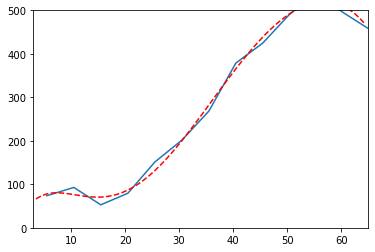

height_distance
Cyclist
<function objective_6f at 0x7ff77600e268>
[-4.57058268e-07  9.42314423e-05 -7.24326131e-03  2.54304051e-01
 -4.03487791e+00  2.73073026e+01 -2.74912541e+01]
[606.6928039802899, 574.6384423751114, 617.6975880725613, 783.1586342372084, 222.01319045167136, 666.8603623763473, 6764.542395305936, 10185.283104918764, 198733.59329212477]


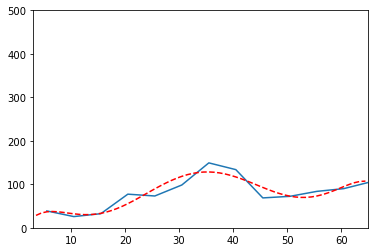

height_distance
Pedestrian
<function objective_7f at 0x7ff77600e1e0>
[ 6.51250933e-09 -1.90747725e-06  2.18493725e-04 -1.22909015e-02
  3.48125557e-01 -4.59704723e+00  2.62522669e+01 -2.65033669e+01]
[488.3465918390032, 501.15779531765935, 491.49782356714223, 589.8225295028717, 291.29870761473154, 250.6495846911027, 513.3173985902567, 4287.937644245057, 2493.264078478366]


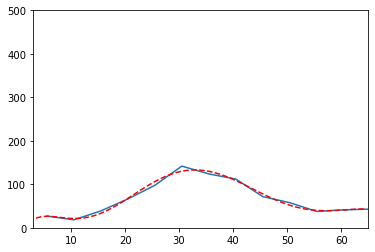

height_2d
Car
<function objective_3f at 0x7ff799b1e378>
[-1.81342029e-04  9.46005734e-02 -1.52141908e+01  7.89660415e+02]
[5642.115006899651, 2991.6452766343705, 4778.364052100179, 7291.899065289078, 7441.885362132, 9629.607558602587, 20222.018586183258, 20827.827895775754, 7902.854742229524]


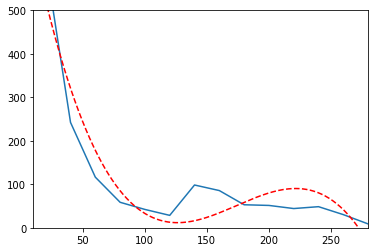

height_2d
Cyclist
<function objective_5f at 0x7ff776467f28>
[ 7.01528666e-09 -5.50496495e-06  1.54911368e-03 -1.83659580e-01
  7.58747079e+00  3.45348567e+01]
[392.80291717725737, 285.9977519605975, 264.750786143407, 250.63915538585144, 297.68805029169886, 592.4581151387807, 2010.6606543654575, 3647.1195455682014, 2162.000032434438]


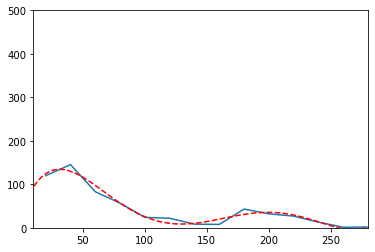

height_2d
Pedestrian
<function objective_6f at 0x7ff77600e268>
[-5.13384533e-11  5.17170595e-08 -2.04826715e-05  3.99451294e-03
 -3.87631275e-01  1.58380094e+01 -9.02605890e+01]
[733.9314399476111, 806.3603575752927, 463.6103554569058, 124.68870915888971, 51.68342526244614, 125.34622643994201, 729.5996505086862, 998.1292667985833, 440.88799848585876]


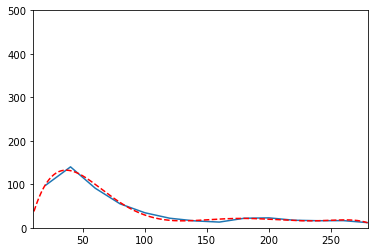

pointcloud_distance
Car
<function objective_2f at 0x7ff776467a60>
[ 3.21589854e-01 -4.39661506e+00  1.01062789e+03]
[52851.78361675526, 56019.7230239057, 56237.5079604868, 145921.11425386352, 144864.99458234943, 1613900.6611851344, 2699493.6942396024, 2667446.61909777, 12588313.780766228]


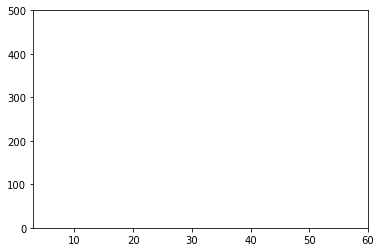

100%|██████████| 7481/7481 [02:19<00:00, 62.21it/s]

pointcloud_distance
Cyclist
<function objective_4f at 0x7ff7764678c8>
[-3.69089938e-03  4.33646833e-01 -1.63739155e+01  2.41027370e+02
 -8.95619317e+02]
[153737.59419870866, 112065.54557815612, 87457.24940029773, 144043.19960091772, 325027.4182846295, 395263.8197557656, 1029805.3590814401, 3691267.3176129633, 12321170.071908671]


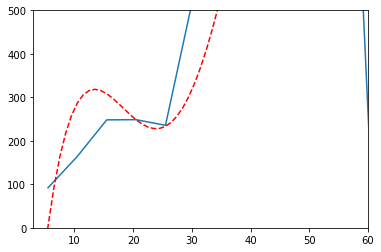

pointcloud_distance
Pedestrian
<function objective_6f at 0x7ff77600e268>
[-2.64005624e-06  4.80300219e-04 -3.17411434e-02  9.29807962e-01
 -1.17020379e+01  7.58442960e+01 -3.84134336e+01]
[41251.40334511218, 54012.10916151374, 72055.39947979542, 59939.75325134703, 39645.58991626073, 162065.44593090942, 73361.09639980496, 1867951.8124493586, 160288188.77181947]


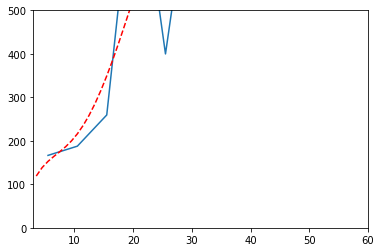

pointcloud_n_points
Car
<function objective_8f at 0x7ff77600e378>
[ 3.32090071e-23 -5.63305935e-19  3.99192470e-15 -1.53178483e-11
  3.45466123e-08 -4.66950581e-05  3.71260607e-02 -1.61963648e+01
  3.27812564e+03]
[194507.01922287032, 122590.89244899804, 78402.47511138757, 65035.205012388156, 51410.05372798035, 30409.34779192463, 18470.880546200155, 21047.89822188265, 467220.0449562721]


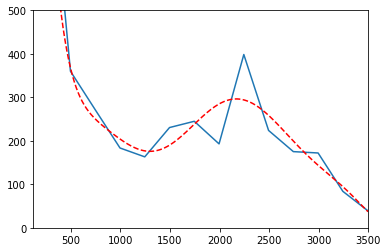

pointcloud_n_points
Cyclist
<function objective_7f at 0x7ff77600e1e0>
[-4.95302727e-21  7.41794017e-17 -4.78242773e-13  1.74267200e-09
 -3.88188083e-06  5.20065320e-03 -3.80020354e+00  1.22040221e+03]
[19313.595130135764, 10047.577057186109, 3660.8832043411085, 1441.28215261174, 1141.3841801119904, 921.6596174522977, 1020.4322876945826, 19794.91557996737, 24055.276898027947]


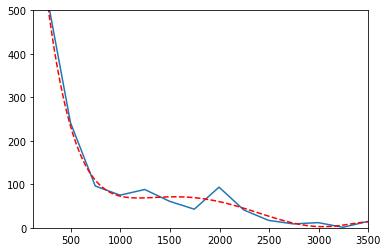

pointcloud_n_points
Pedestrian
<function objective_9f at 0x7ff77600e400>
[-1.23149375e-25  2.06908026e-21 -1.47802940e-17  5.85576956e-14
 -1.40700730e-10  2.10501237e-07 -1.93661895e-04  1.04286805e-01
 -2.96365028e+01  3.54185592e+03]
[157656.4269670218, 124426.93132522042, 101408.63423142102, 113290.56391662937, 108756.776998646, 92379.96671304463, 94716.26897209224, 53184.645660172224, 330778.7282840962]


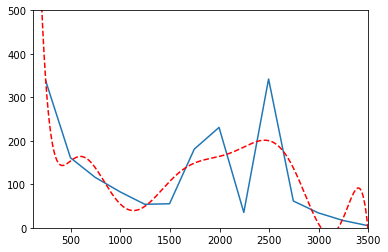

In [56]:
dict_models = {'height_distance':{'Car':None,'Cyclist':None,'Pedestrian':None},
               'height_2d':{'Car':None,'Cyclist':None,'Pedestrian':None},
               'pointcloud_distance':{'Car':None,'Cyclist':None,'Pedestrian':None},
               'pointcloud_n_points':{'Car':None,'Cyclist':None,'Pedestrian':None}}

# Variables for the different error models
jumps = [5, 20, 5, 250]
starts = [3, 10, 3, 120]
ends = [65, 280, 60, 3500]

functions = [objective_2f, objective_3f, objective_4f, objective_5f, objective_6f, objective_7f, objective_8f, objective_9f, objective_10f]
error_model_names = ['height_distance', 'height_2d', 'pointcloud_distance', 'pointcloud_n_points']
model_columns = ['distance_height', 'height_image', 'distance_pointcloud', 'n_points']
class_names = ['Car', 'Cyclist', 'Pedestrian']

# Loop over error models
for error_model_name, model_column, jump, start, end in zip(error_model_names, model_columns,jumps, starts, ends):
    # Loop over class names
    for class_name in class_names:
        
        approximate_distance_column = 'distance_' + error_model_name.split("_")[0]
        
        df_train_class = df_train[df_train['type'] == class_name]
    
        # Calculate deciles
        MPointE_points = []
        for point in range(start, end, jump):
            MPointE_point = df_train_class[(point < df_train_class[model_column]) & \
                                               (df_train_class[model_column] < point+jump)].apply(lambda row: row['distance']-row[approximate_distance_column],
                                                                                                        axis=1).quantile(q=[0.01,0.99])
            MPointE_points.append(MPointE_point)
        q_0_01 = list(map(lambda x: x.get(0.01), MPointE_points))
        q_0_99 = list(map(lambda x: x.get(0.99), MPointE_points))

        # Create axis
        Y = [(x1 - x2)**2 for (x1, x2) in zip(q_0_99, q_0_01)]
        X = (np.array(list(range(start,end,jump)))+jump/2).tolist()
        
        # Only one function with training data is to be created, so the validation dataset is not necessary
        start_ = int(start - jump/2)
        end_ = int(end + jump/2)
        MPointE_points_ = []
        for point in range(start_, end_, jump):
            MPointE_point = df_train_class[(point < df_train_class[model_column]) & \
                                               (df_train_class[model_column] < point+jump)].apply(lambda row: row['distance']-row[approximate_distance_column],
                                                                                                        axis=1).quantile(q=[0.01,0.99])
            MPointE_points_.append(MPointE_point)
        q_0_01_ = list(map(lambda x: x.get(0.01), MPointE_points_))
        q_0_99_ = list(map(lambda x: x.get(0.99), MPointE_points_))
        Y_val = [(x1 - x2)**2 for (x1, x2) in zip(q_0_99_, q_0_01_)]
        X_val = (np.array(list(range(start_,end_,jump)))+jump/2).tolist()
        
        
        popt_functions = list(map(lambda function: curve_fit(function, X, Y,maxfev = 1000000)[0], functions))
        mses_class_model_error = list(map(lambda function, popt: mean_squared_error(Y_val, list(map(lambda x: function(x, *popt), X_val))), functions, popt_functions))
        
        min_mse = min(mses_class_model_error)
        id_function = mses_class_model_error.index(min_mse)
        function = functions[id_function]
        popt = popt_functions[id_function]
        
        X_line = (np.array(list(range(start,end,1)))+1/2).tolist()
        
        dict_models[error_model_name][class_name] = Regression_model(function, popt)
        
        print(error_model_name)
        print(class_name)
        print(function)
        print(popt)
        print(mses_class_model_error)
        plt.plot(X, Y)
        plt.plot(X_line, list(map(lambda x: function(x, *popt), X_line)), '--', color='red')
        plt.xlim((start,end))
        plt.ylim((0,500))
        plt.show()

In [57]:
error_model = get_error_model(dict_models)

In [58]:
error_model = Regression_model_error(Regression_model_class(dict_models['height_distance']['Car'],
                                                             dict_models['height_distance']['Cyclist'],
                                                             dict_models['height_distance']['Pedestrian']),
                                      Regression_model_class(dict_models['height_2d']['Car'],
                                                             dict_models['height_2d']['Cyclist'],
                                                             dict_models['height_2d']['Pedestrian']),
                                      Regression_model_class(dict_models['pointcloud_distance']['Car'],
                                                             dict_models['pointcloud_distance']['Car'],
                                                             dict_models['pointcloud_distance']['Car']),
                                      Regression_model_class(dict_models['pointcloud_n_points']['Car'],
                                                             dict_models['pointcloud_n_points']['Cyclist'],
                                                             dict_models['pointcloud_n_points']['Pedestrian']))

In [59]:
df_train['distance_ensemble4'] = df_train.apply(lambda row: ajust_distance(error_model,
                                                                          row['distance_height'],
                                                                          row['height_image'],
                                                                          row['distance_pointcloud'],
                                                                          row['n_points'],
                                                                          row['type']) if row['distance_pointcloud'] != None else row['distance_height'], axis=1)
df_val['distance_ensemble4'] = df_val.apply(lambda row: ajust_distance(error_model,
                                                                      row['distance_height'],
                                                                      row['height_image'],
                                                                      row['distance_pointcloud'],
                                                                      row['n_points'],
                                                                      row['type']) if row['distance_pointcloud'] != None else row['distance_height'], axis=1)

In [60]:
evaluate('distance_ensemble4')

################################

--- 0.0004057884216308594 seconds to calculate MSE, Easy difficulty, Car class  ---

Mean of all MSE by frame, Easy difficulty, Car class = 4.100104461173989

--- 0.0002372264862060547 seconds to calculate MSE, Easy difficulty, Cyclist class  ---

Mean of all MSE by frame, Easy difficulty, Cyclist class = 1.4783399675941837

--- 0.00025844573974609375 seconds to calculate MSE, Easy difficulty, Pedestrian class  ---

Mean of all MSE by frame, Easy difficulty, Pedestrian class = 1.9317495100160795

################################

--- 0.0004546642303466797 seconds to calculate MSE, Moderate difficulty, Car class  ---

Mean of all MSE by frame, Moderate difficulty, Car class = 7.629947275445252

--- 0.0003654956817626953 seconds to calculate MSE, Moderate difficulty, Cyclist class  ---

Mean of all MSE by frame, Moderate difficulty, Cyclist class = 2.5769812186871963

--- 0.00027561187744140625 seconds to calculate MSE, Moderate difficulty, Pedestrian cl

# Error of the ensemble model

In [61]:
df_train['error_distance_ensemble4'] = df_train['distance'] - df_train['distance_ensemble4']
df_val['error_distance_ensemble4'] = df_val['distance'] - df_val['distance_ensemble4']

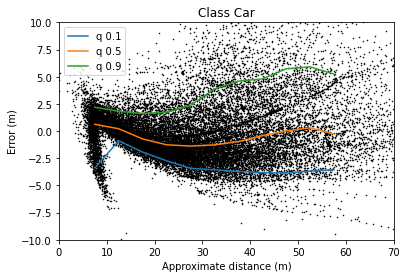

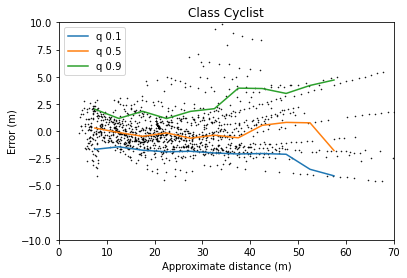

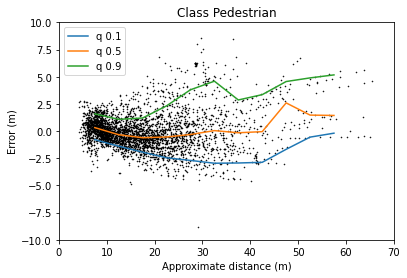

In [62]:
jump = 5
start = 5
end = 60

# Loop over classes
for class_name in ["Car","Cyclist","Pedestrian"]:
    df_train_class = df_train[df_train['type'] == class_name]
    
    # Calculate quartiles
    MDistanceE_distances = []
    for distance in range(start, end, jump):
        MDistanceE_distance = df_train_class[(distance < df_train_class['distance_ensemble4']) & \
                                           (df_train_class['distance_ensemble4'] < distance+jump)].apply(lambda row: row['distance']-row['distance_ensemble4'],
                                                                                                    axis=1).quantile(q=[0.1,0.5,0.9])
        MDistanceE_distances.append(MDistanceE_distance)
    q_0_1 = list(map(lambda x: x.get(0.1), MDistanceE_distances))
    q_0_5 = list(map(lambda x: x.get(0.5), MDistanceE_distances))
    q_0_9 = list(map(lambda x: x.get(0.9), MDistanceE_distances))

    Y = df_train_class['error_distance_ensemble4'].values
    X = df_train_class['distance_ensemble4'].values

    plt.title("Class %s" % class_name)
    plt.xlabel('Approximate distance (m)')
    plt.ylabel('Error (m)')

    plt.scatter(X, Y, s=0.3, c='black')
    
    x = np.array(list(range(start,end,jump)))+jump/2
    plt.plot(x, q_0_1)
    plt.plot(x, q_0_5)
    plt.plot(x, q_0_9)
    plt.legend(['q 0.1', 'q 0.5', 'q 0.9'])
    
    plt.xlim((0,70))
    plt.ylim((-10,10))
    
    #plt.grid(alpha=0.5)
    
    plt.show()

In [63]:
df_val['error_distance_ensemble4'].quantile(q=[0.01,0.05,0.5,0.95,0.99])

0.01   -5.286798
0.05   -3.791298
0.50   -0.430709
0.95    4.795020
0.99    8.786520
Name: error_distance_ensemble4, dtype: float64

In [64]:
df_val[df_val['distance'] < 50]['error_distance_ensemble4'].quantile(q=[0.01,0.05,0.5,0.95,0.99])

0.01   -5.111959
0.05   -3.776374
0.50   -0.530117
0.95    3.719954
0.99    6.754183
Name: error_distance_ensemble4, dtype: float64

# Save last model

In [65]:
error_model = Regression_model_error(Regression_model_class(dict_models['height_distance']['Car'],
                                                             dict_models['height_distance']['Cyclist'],
                                                             dict_models['height_distance']['Pedestrian']),
                                      Regression_model_class(dict_models['height_2d']['Car'],
                                                             dict_models['height_2d']['Cyclist'],
                                                             dict_models['height_2d']['Pedestrian']),
                                      Regression_model_class(dict_models['pointcloud_distance']['Car'],
                                                             dict_models['pointcloud_distance']['Car'],
                                                             dict_models['pointcloud_distance']['Car']),
                                      Regression_model_class(dict_models['pointcloud_n_points']['Car'],
                                                             dict_models['pointcloud_n_points']['Cyclist'],
                                                             dict_models['pointcloud_n_points']['Pedestrian']))

In [66]:
with open('error_model.pkl', 'wb') as f:
    f.write(pickle.dumps(error_model))